# Modeling RTT

In [495]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from phila_style import *
from phila_style.matplotlib import get_theme

In [496]:
from fbprophet import Prophet

In [497]:
palette = get_default_palette()

## 1. Load data

### RTT data

In [499]:
rtt_sectors = pd.read_excel("../../data/01_raw/historical/rtt/quarterly-rtt-data.xlsx")
rtt_sectors["total_per_record"] = rtt_sectors["total"] / rtt_sectors["num_records"]

In [500]:
nonres = rtt_sectors.query("sector == 'Non-Residential'")
res = rtt_sectors.query("sector == 'Residential'")

**Note:**

Forecasted FY22 Q4 total is $170M

In [420]:
cbo = pd.read_csv("../../data/01_raw/cbo/2022-05-economic-projections.csv").assign(
    date=lambda df: pd.to_datetime(df.date)
)

In [514]:
cbo_res = (
    cbo.set_index("date")
    .join(res.set_index("date")[["num_records", "total_per_record"]])
    .dropna()
    .corr()
    .loc[["num_records", "total_per_record"]]
    .T.sort_values(["num_records", "total_per_record"], ascending=False)
    .dropna()
)

cbo_res.head(20)

,num_records,total_per_record
num_records,1.000000,0.236087
empl_civ_16yo,0.677292,0.371764
hours_nfb,0.669003,0.455326
empl_payroll_nf,0.656029,0.434741
real_imports,0.615321,0.708146
output_gap,0.577285,0.063158
real_exports,0.565094,-0.054003
labor_force,0.553876,0.625135
real_gross_pri_dom_invest,0.535127,0.813073
real_gnp,0.512549,0.790323


In [510]:
cbo_nonres = (
    cbo.set_index("date")
    .join(nonres.set_index("date")[["num_records", "total_per_record"]])
    .corr()
    .loc[["num_records", "total_per_record"]]
    .T.sort_values(["num_records", "total_per_record"], ascending=False)
    .dropna()
)

cbo_nonres

,num_records,total_per_record
num_records,1.000000,-0.020065
empl_civ_16yo,0.736273,0.083252
hours_nfb,0.725784,0.067517
empl_payroll_nf,0.719619,0.163025
real_exports,0.680977,-0.159959
...,...,...
oil_price_wti_spot,-0.340573,-0.101150
oil_rac_imported,-0.353624,-0.078799
real_net_exports,-0.363319,-0.301036
prop_inc_farm_adj,-0.510339,0.014599


## 2. Exploratory Analysis

## Residential vs. Non-Residential

In [427]:
# Total by quarter
total = nonres.set_index("date")["total"] + res.set_index("date")["total"]

total / 1e6

date
2013-01-01     36.104693
2013-04-01     39.797834
2013-07-01     38.349421
2013-10-01     39.168202
2014-01-01     35.661678
2014-04-01     48.170833
2014-07-01     47.982018
2014-10-01     49.902782
2015-01-01     37.085933
2015-04-01     63.872352
2015-07-01     66.761236
2015-10-01     55.553410
2016-01-01     58.253203
2016-04-01     55.185437
2016-07-01     61.579822
2016-10-01     62.315038
2017-01-01     53.249974
2017-04-01     66.092037
2017-07-01     83.502464
2017-10-01     81.687041
2018-01-01     83.350157
2018-04-01     84.812316
2018-07-01     87.217967
2018-10-01     78.445963
2019-01-01     58.850080
2019-04-01    102.106981
2019-07-01     91.266641
2019-10-01     81.151051
2020-01-01     89.356422
2020-04-01     54.831637
2020-07-01     70.091507
2020-10-01     89.304112
2021-01-01     62.070514
2021-04-01     79.469764
2021-07-01     60.846242
2021-10-01    137.608101
2022-01-01    195.813482
Name: total, dtype: float64

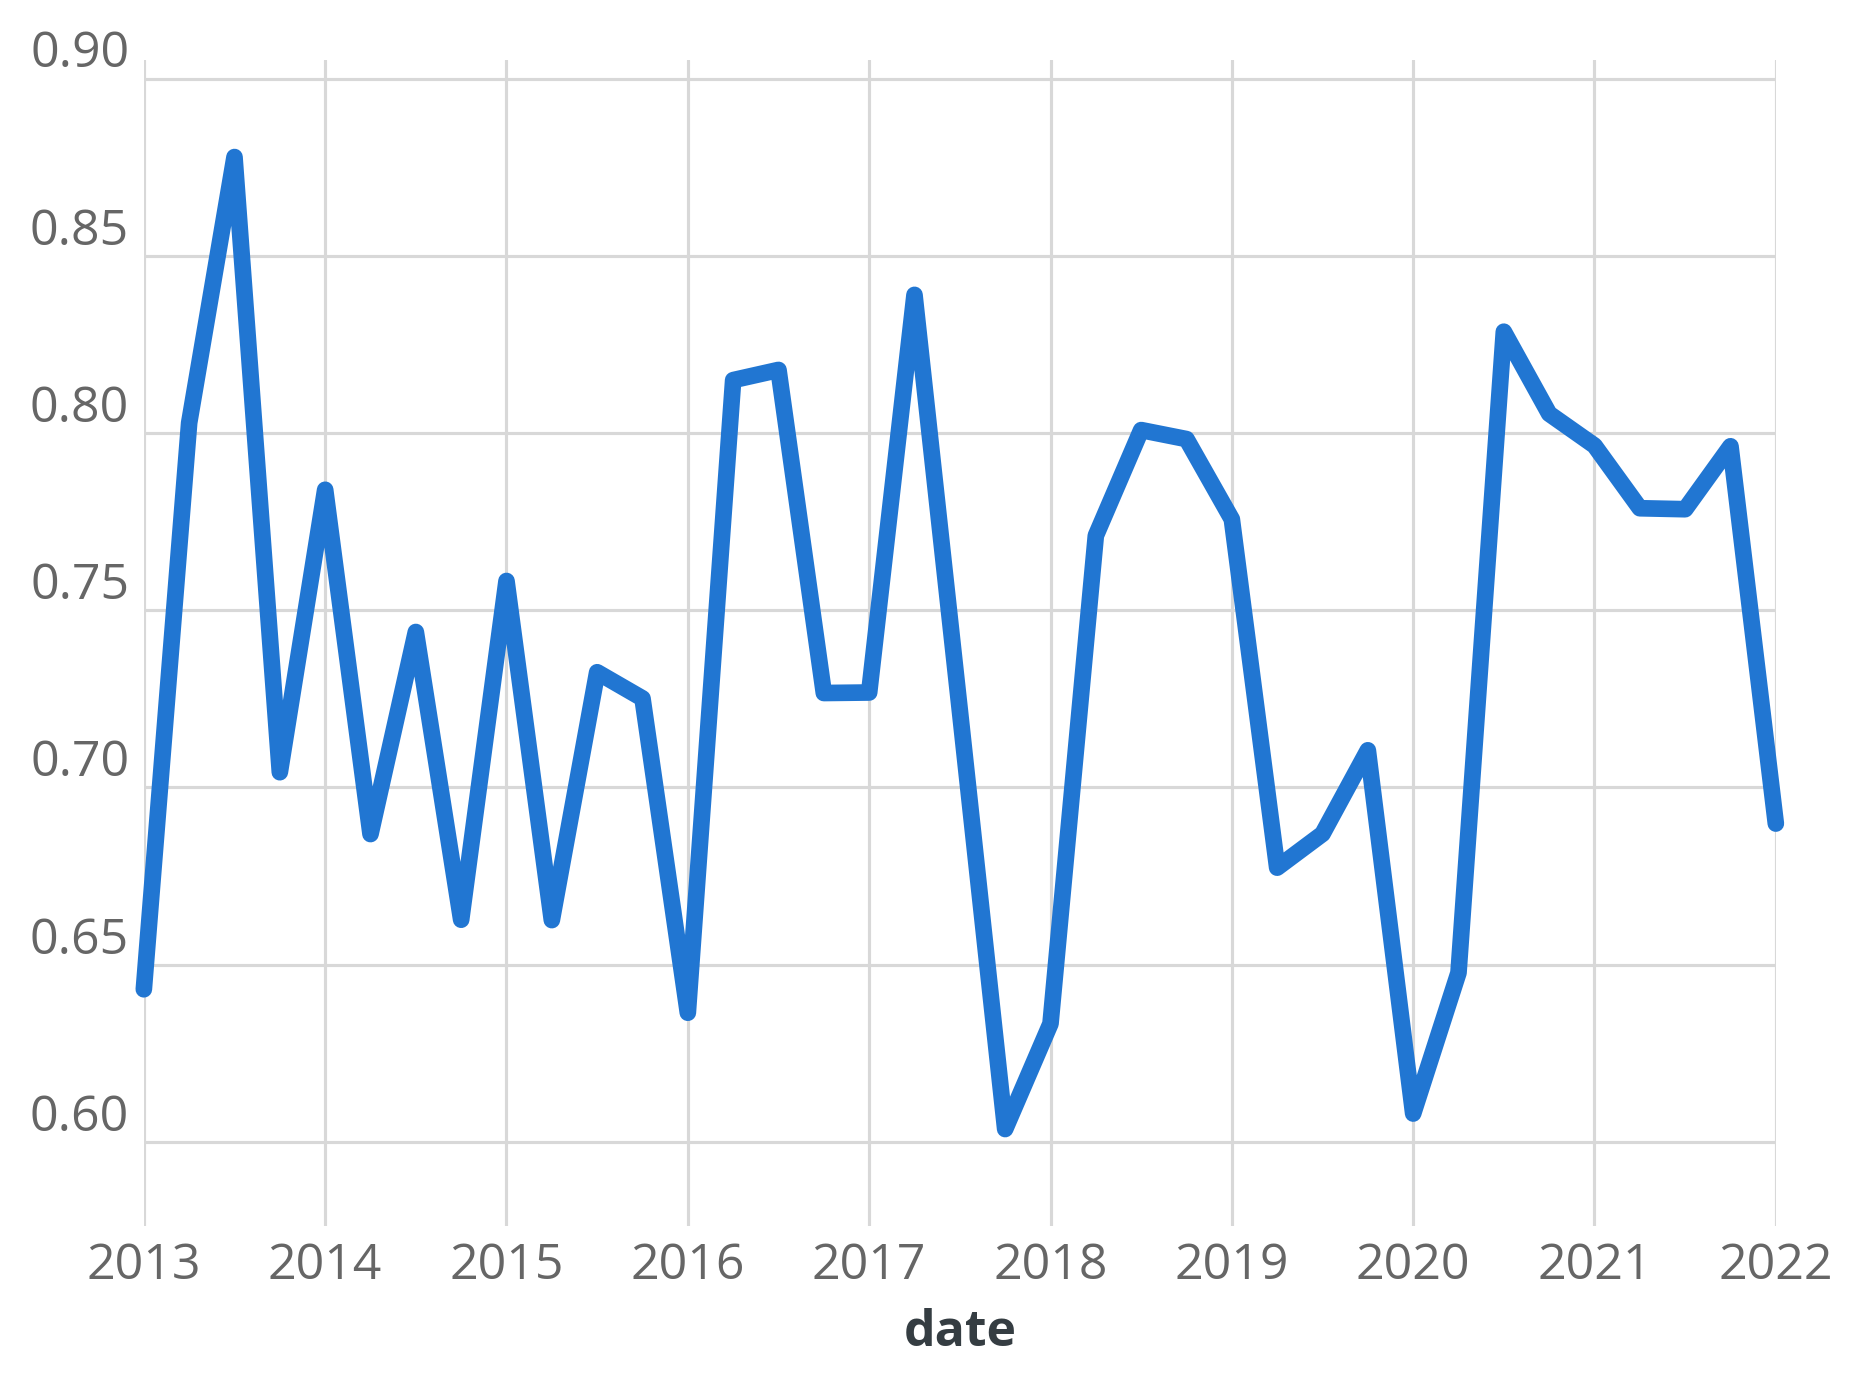

In [428]:
# Residential fraction
with plt.style.context(get_theme()):
    f = res.set_index("date")["total"] / total
    f.plot(clip_on=False)

### Residential Sales

In [429]:
res.tail()

,date,sector,num_records,total,total_per_record
359,2021-01-01,Residential,6877,49434102,7188.323688
370,2021-04-01,Residential,8372,61887311,7392.177616
381,2021-07-01,Residential,6553,47367396,7228.352816
392,2021-10-01,Residential,10328,109568669,10608.895139
403,2022-01-01,Residential,15890,135068715,8500.233795


#### Number of sales

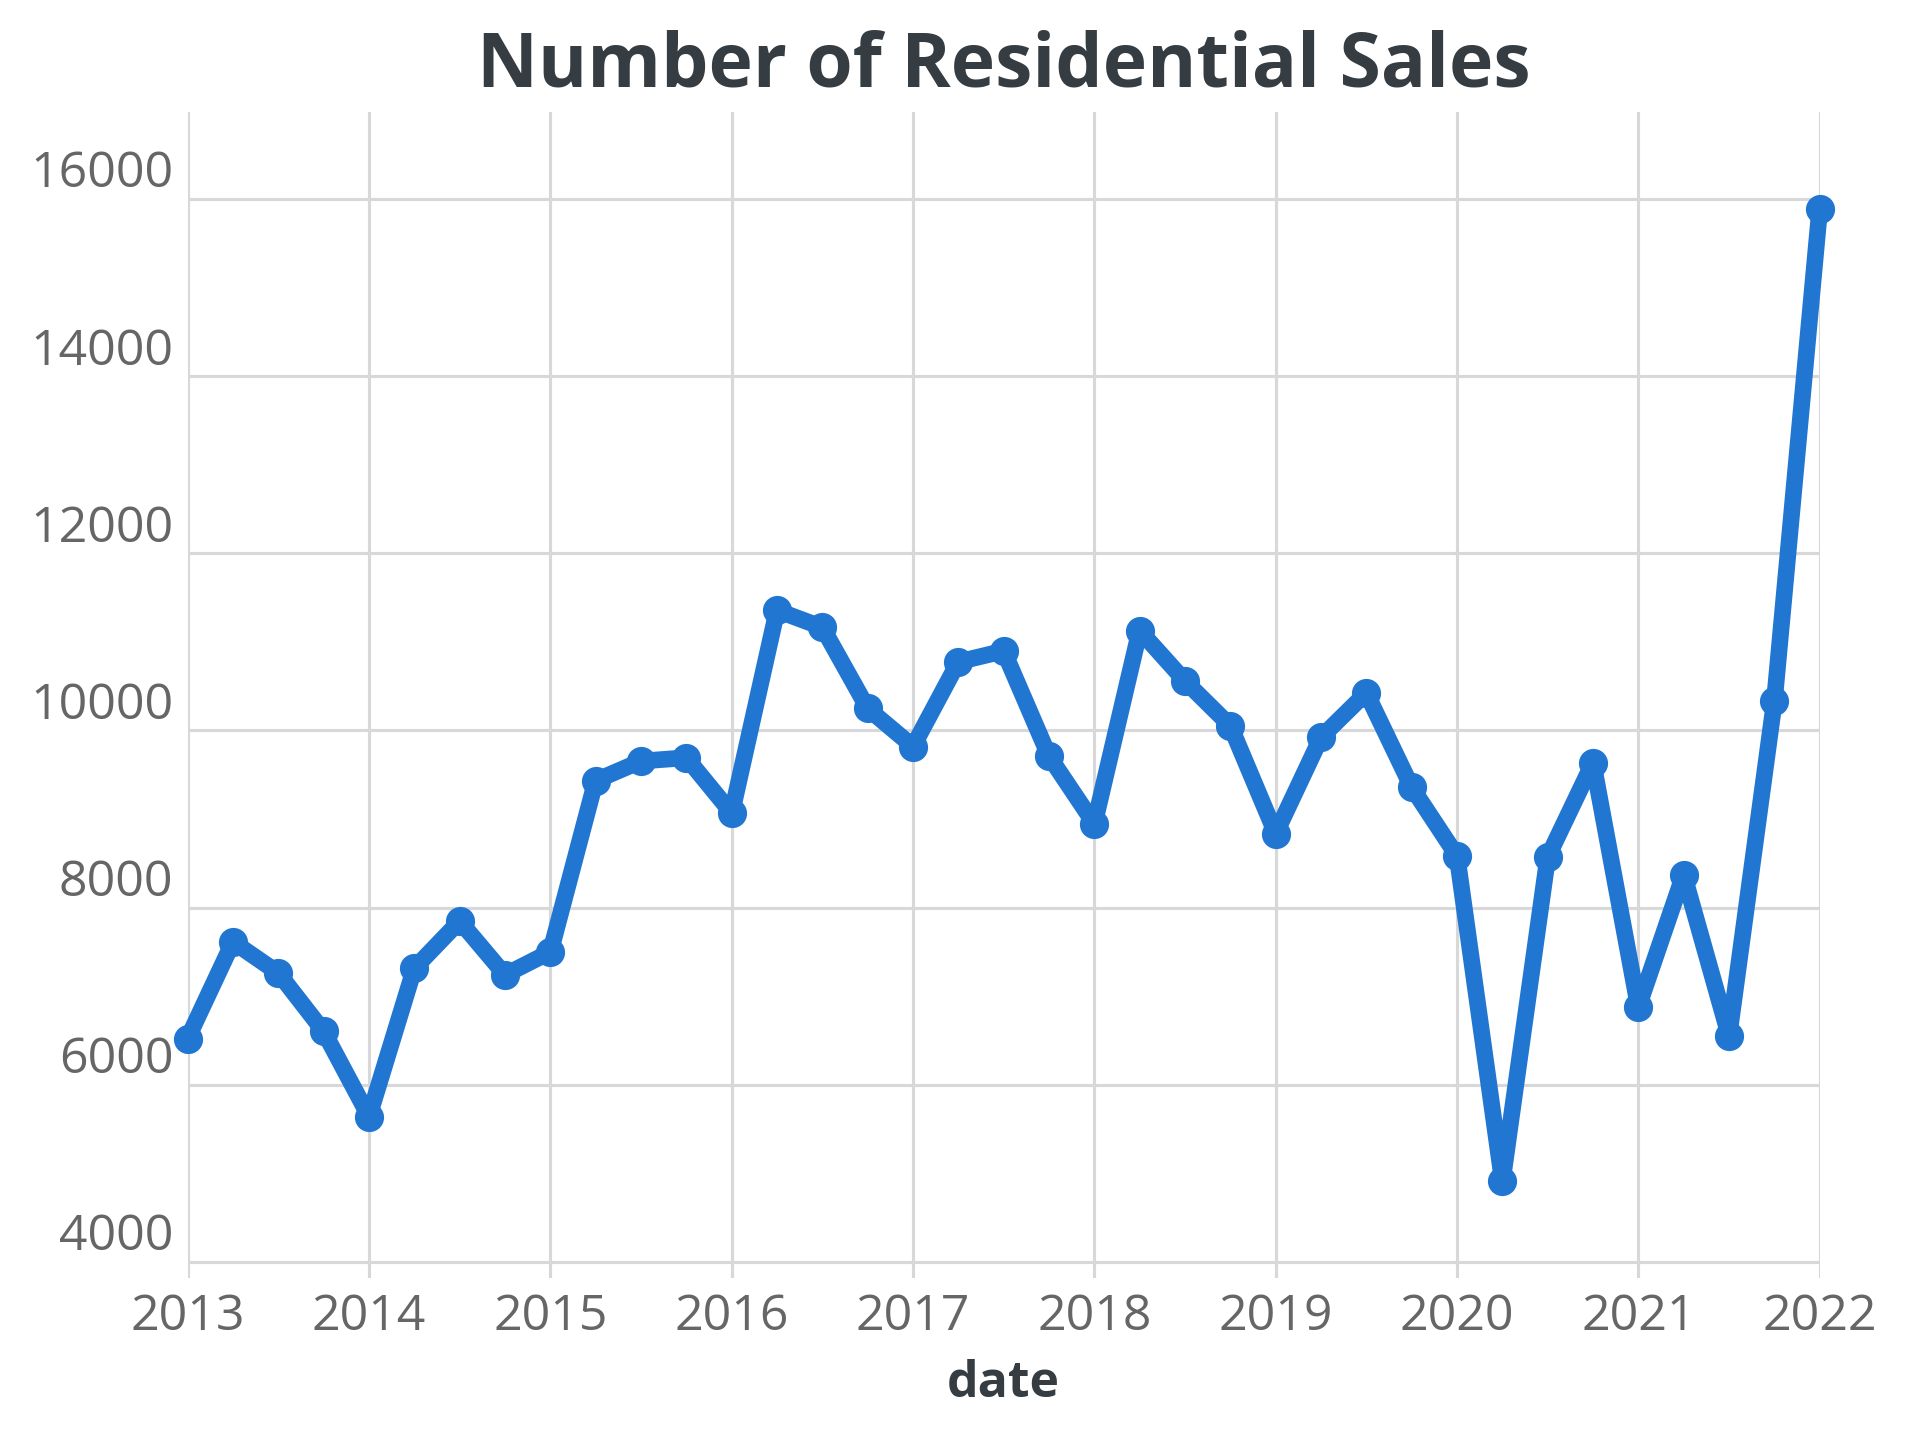

In [430]:
with plt.style.context(get_theme()):
    ax = res.plot(x="date", y="num_records", legend=False, clip_on=False, marker="o")
    ax.set_title("Number of Residential Sales")

In [502]:
def get_forecast(
    data,
    column,
    covid_dates={"2020-04-01": 1, "2020-07-01": 0.5, "2020-10-01": 0.25},
    abatement_dates={
        "2021-10-01": 0.5,
        "2022-01-01": 1,
        "2022-04-01": 0.5,
    },
    cbo_regressor=None,
    **fit_kwargs
):

    fit_kwargs.setdefault("daily_seasonality", False)
    fit_kwargs.setdefault("weekly_seasonality", False)

    if cbo_regressor is not None:
        if isinstance(cbo_regressor, str):
            cbo_regressor = [cbo_regressor]
    else:
        cbo_regressor = []

    # Format the input data
    df = (
        data.set_index("date")[column]
        .rename_axis("ds")
        .reset_index()
        .rename(columns={column: "y"})
        .sort_values("ds")
    )

    def custom_regressor(ds, dates):
        """Custom regressor function"""
        date = ds.strftime("%Y-%m-%d")
        if date in dates:
            return dates[date]
        else:
            return 0

    def cbo_regressor_func(ds, cbo_indicator):
        """Custom regressor function"""
        if ds in cbo_indicator.index:
            return cbo_indicator.loc[ds]
        else:
            return 0

    df["covid"] = df["ds"].apply(custom_regressor, args=(covid_dates,))
    df["abatement"] = df["ds"].apply(custom_regressor, args=(abatement_dates,))

    # CBO regressor
    for col in cbo_regressor:
        df[col] = df["ds"].apply(
            cbo_regressor_func, args=(cbo.set_index("date")[col].dropna().squeeze(),)
        )

    model = Prophet(**fit_kwargs)
    model.add_regressor("covid")
    model.add_regressor("abatement")
    for col in cbo_regressor:
        model.add_regressor(col)
    model.fit(df)

    future = model.make_future_dataframe(periods=4 * 5 + 1, freq="QS")
    future["covid"] = future["ds"].apply(custom_regressor, args=(covid_dates,))
    future["abatement"] = future["ds"].apply(custom_regressor, args=(abatement_dates,))
    for col in cbo_regressor:
        future[col] = future["ds"].apply(
            cbo_regressor_func, args=(cbo.set_index("date")[col].dropna().squeeze(),)
        )

    forecast = model.predict(future)
    return model, forecast

/Users/nicholashand/Library/Caches/pypoetry/virtualenvs/fyp-analysis-ZVW_eOe5-py3.9/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)



Initial log joint probability = -55.5279
Iteration  1. Log joint probability =    28.4574. Improved by 83.9853.
Iteration  2. Log joint probability =    43.3979. Improved by 14.9405.
Iteration  3. Log joint probability =    51.7997. Improved by 8.40177.
Iteration  4. Log joint probability =    63.5941. Improved by 11.7945.
Iteration  5. Log joint probability =    69.9734. Improved by 6.37926.
Iteration  6. Log joint probability =    69.9861. Improved by 0.0126982.
Iteration  7. Log joint probability =    70.1034. Improved by 0.117329.
Iteration  8. Log joint probability =     70.119. Improved by 0.0156005.
Iteration  9. Log joint probability =    70.1487. Improved by 0.0296259.
Iteration 10. Log joint probability =    70.1561. Improved by 0.00741004.
Iteration 11. Log joint probability =    70.1688. Improved by 0.0127705.
Iteration 12. Log joint probability =    70.1752. Improved by 0.00639044.
Iteration 13. Log joint probability =    70.3526. Improved by 0.177341.
Iteration 14. Log j

/Users/nicholashand/Library/Caches/pypoetry/virtualenvs/fyp-analysis-ZVW_eOe5-py3.9/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/nicholashand/Library/Caches/pypoetry/virtualenvs/fyp-analysis-ZVW_eOe5-py3.9/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


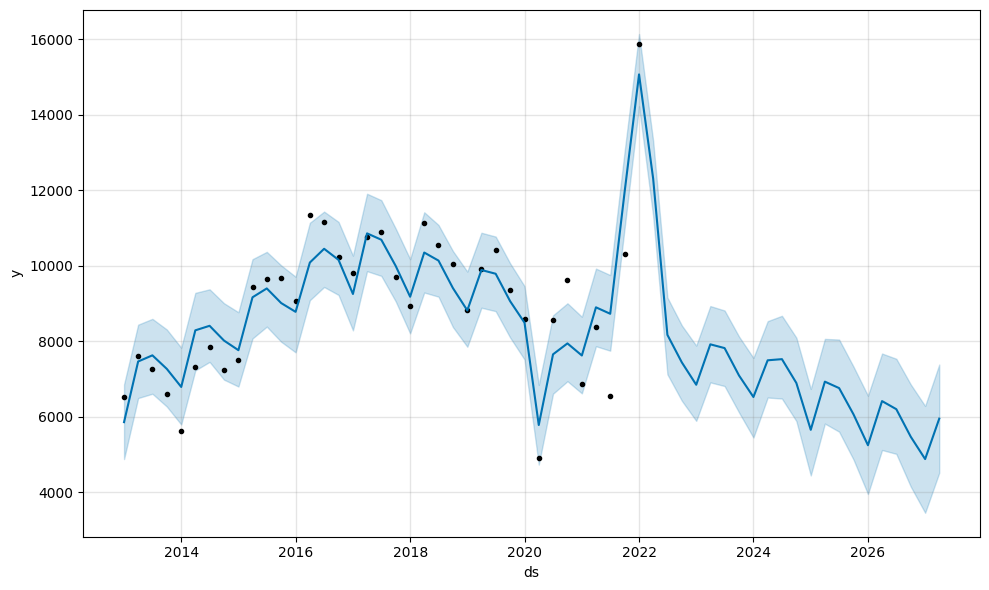

In [525]:
model, residential_sales = get_forecast(
    res, "num_records"
)
model.plot(residential_sales);

/Users/nicholashand/Library/Caches/pypoetry/virtualenvs/fyp-analysis-ZVW_eOe5-py3.9/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)



Initial log joint probability = -54.7304
Iteration  1. Log joint probability =    42.4174. Improved by 97.1479.
Iteration  2. Log joint probability =    63.4119. Improved by 20.9944.
Iteration  3. Log joint probability =    86.5054. Improved by 23.0935.
Iteration  4. Log joint probability =    91.4722. Improved by 4.96681.
Iteration  5. Log joint probability =    93.1227. Improved by 1.65054.
Iteration  6. Log joint probability =    93.1584. Improved by 0.0356526.
Iteration  7. Log joint probability =    93.1954. Improved by 0.0370603.
Iteration  8. Log joint probability =    93.3019. Improved by 0.106469.
Iteration  9. Log joint probability =    94.0087. Improved by 0.70678.
Iteration 10. Log joint probability =    94.4982. Improved by 0.489486.
Iteration 11. Log joint probability =    95.6579. Improved by 1.15976.
Iteration 12. Log joint probability =    95.8375. Improved by 0.179541.
Iteration 13. Log joint probability =    95.9757. Improved by 0.138256.
Iteration 14. Log joint pro

/Users/nicholashand/Library/Caches/pypoetry/virtualenvs/fyp-analysis-ZVW_eOe5-py3.9/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/nicholashand/Library/Caches/pypoetry/virtualenvs/fyp-analysis-ZVW_eOe5-py3.9/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


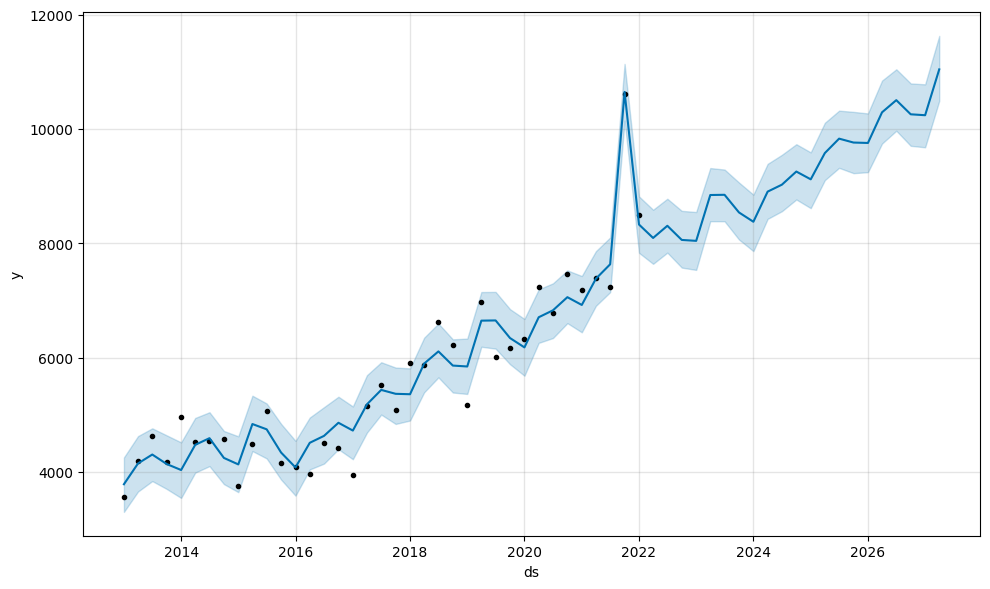

In [486]:
model, residential_prices = get_forecast(
    res,
    "total_per_record",
    covid_dates={},
    abatement_dates={
        "2021-10-01": 1,
        "2022-01-01": 0.25,
    },
    use_fed_funds_rate=False,
    use_hpi=False
)
model.plot(residential_prices);

In [487]:
R = (
    residential_prices.set_index("ds")["yhat"]
    * residential_sales.set_index("ds")["yhat"]
)

R / 1e6

ds
2013-01-01     22.185734
2013-04-01     30.983347
2013-07-01     32.849907
2013-10-01     30.097781
2014-01-01     27.405432
2014-04-01     37.110199
2014-07-01     38.625246
2014-10-01     34.059216
2015-01-01     32.094092
2015-04-01     44.362187
2015-07-01     44.625810
2015-10-01     39.123165
2016-01-01     35.825514
2016-04-01     45.502292
2016-07-01     48.412016
2016-10-01     49.382636
2017-01-01     43.729201
2017-04-01     56.302454
2017-07-01     58.125821
2017-10-01     53.665144
2018-01-01     49.225694
2018-04-01     61.052952
2018-07-01     61.955934
2018-10-01     55.174813
2019-01-01     51.562597
2019-04-01     65.757123
2019-07-01     65.134683
2019-10-01     57.510297
2020-01-01     52.509196
2020-04-01     38.811121
2020-07-01     52.296027
2020-10-01     56.099577
2021-01-01     52.802216
2021-04-01     65.725293
2021-07-01     66.667594
2021-10-01    127.417222
2022-01-01    125.559168
2022-04-01    115.587732
2022-07-01     67.913060
2022-10-01     60.0131

/Users/nicholashand/Library/Caches/pypoetry/virtualenvs/fyp-analysis-ZVW_eOe5-py3.9/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)



Initial log joint probability = -55.6047
Iteration  1. Log joint probability =    27.2715. Improved by 82.8762.
Iteration  2. Log joint probability =    48.1689. Improved by 20.8974.
Iteration  3. Log joint probability =    61.5739. Improved by 13.4049.
Iteration  4. Log joint probability =    63.0028. Improved by 1.42889.
Iteration  5. Log joint probability =    63.2725. Improved by 0.269764.
Iteration  6. Log joint probability =    63.3169. Improved by 0.0443414.
Iteration  7. Log joint probability =      63.33. Improved by 0.0131041.
Iteration  8. Log joint probability =    63.3549. Improved by 0.0249371.
Iteration  9. Log joint probability =    63.3608. Improved by 0.00585278.
Iteration 10. Log joint probability =    63.3635. Improved by 0.00277102.
Iteration 11. Log joint probability =    63.3664. Improved by 0.00286744.
Iteration 12. Log joint probability =    63.3717. Improved by 0.00531895.
Iteration 13. Log joint probability =    63.3731. Improved by 0.0014146.
Iteration 14. 

/Users/nicholashand/Library/Caches/pypoetry/virtualenvs/fyp-analysis-ZVW_eOe5-py3.9/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/nicholashand/Library/Caches/pypoetry/virtualenvs/fyp-analysis-ZVW_eOe5-py3.9/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


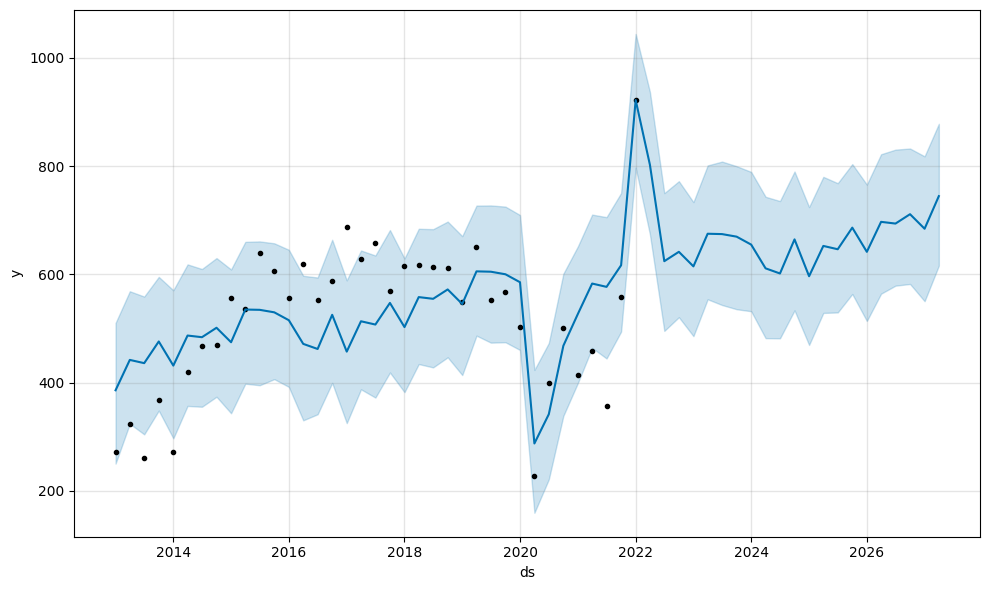

In [488]:
model, nonresidential_sales = get_forecast(
    nonres,
    "num_records",
    covid_dates={
        "2020-04-01": 1,
        "2020-07-01": 0.75,
        "2020-10-01": 0.5,
    },
    abatement_dates={
        "2022-01-01": 1,
        "2022-04-01": 0.5,
        "2022-07-01": 0.,
        "2022-10-01": 0.,
    },
)
model.plot(nonresidential_sales);

/Users/nicholashand/Library/Caches/pypoetry/virtualenvs/fyp-analysis-ZVW_eOe5-py3.9/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)



Initial log joint probability = -56.1701
Iteration  1. Log joint probability =    1.86295. Improved by 58.0331.
Iteration  2. Log joint probability =     45.253. Improved by 43.3901.
Iteration  3. Log joint probability =    54.8122. Improved by 9.55914.
Iteration  4. Log joint probability =    56.7752. Improved by 1.96308.
Iteration  5. Log joint probability =    57.6591. Improved by 0.883832.
Iteration  6. Log joint probability =    58.5793. Improved by 0.920234.
Iteration  7. Log joint probability =    58.6694. Improved by 0.090153.
Iteration  8. Log joint probability =     58.768. Improved by 0.0985539.
Iteration  9. Log joint probability =    58.8179. Improved by 0.0498817.
Iteration 10. Log joint probability =    58.8336. Improved by 0.0157338.
Iteration 11. Log joint probability =     58.847. Improved by 0.0133318.
Iteration 12. Log joint probability =     58.847. Improved by 6.0835e-05.
Iteration 13. Log joint probability =     58.855. Improved by 0.00794541.
Iteration 14. Log 

/Users/nicholashand/Library/Caches/pypoetry/virtualenvs/fyp-analysis-ZVW_eOe5-py3.9/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/nicholashand/Library/Caches/pypoetry/virtualenvs/fyp-analysis-ZVW_eOe5-py3.9/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


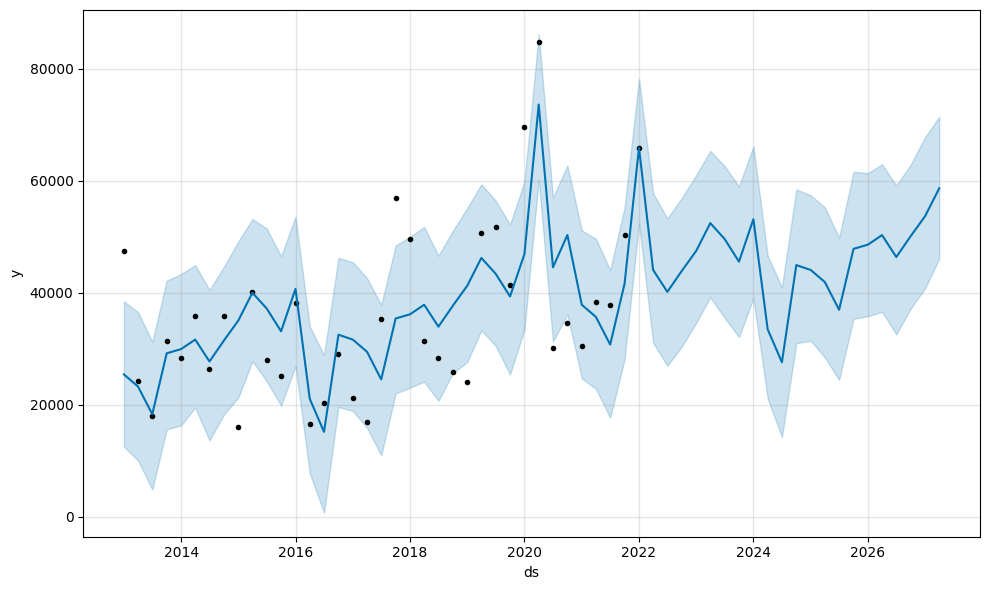

In [489]:
model, nonresidential_prices = get_forecast(
    nonres,
    "total_per_record",
    abatement_dates={
        "2022-01-01": 1,
    },
)
model.plot(nonresidential_prices);

In [490]:
NR = (
    nonresidential_prices.set_index("ds")["yhat"]
    * nonresidential_sales.set_index("ds")["yhat"]
)

NR / 1e6

ds
2013-01-01     9.809773
2013-04-01    10.280973
2013-07-01     7.984492
2013-10-01    13.897834
2014-01-01    12.922757
2014-04-01    15.414555
2014-07-01    13.422031
2014-10-01    15.779501
2015-01-01    16.635094
2015-04-01    21.409413
2015-07-01    19.883152
2015-10-01    17.555388
2016-01-01    20.977347
2016-04-01     9.931997
2016-07-01     7.006416
2016-10-01    17.083122
2017-01-01    14.469568
2017-04-01    15.133872
2017-07-01    12.445372
2017-10-01    19.381204
2018-01-01    18.179575
2018-04-01    21.133585
2018-07-01    18.839896
2018-10-01    21.566077
2019-01-01    22.503259
2019-04-01    27.998454
2019-07-01    26.264849
2019-10-01    23.616979
2020-01-01    27.475628
2020-04-01    21.174372
2020-07-01    15.218488
2020-10-01    23.559056
2021-01-01    19.955088
2021-04-01    20.814591
2021-07-01    17.741757
2021-10-01    25.681454
2022-01-01    60.782226
2022-04-01    35.384039
2022-07-01    25.083147
2022-10-01    28.176720
2023-01-01    29.195301
2023-04-01   

In [491]:
total_revenue = R + NR
total_revenue.index = [dt.year for dt in total_revenue.index.shift(2, freq="QS")]
total_revenue.reset_index().rename(
    columns={"index": "fiscal_year", "yhat": "total"}
).groupby("fiscal_year")["total"].sum() / 1e6

fiscal_year
2013     73.259827
2014    177.682957
2015    216.386780
2016    233.424665
2017    251.519285
2018    293.209345
2019    325.358152
2020    312.497125
2021    306.470336
2022    574.821192
2023    371.010584
2024    370.650697
2025    350.056506
2026    366.081776
2027    385.468982
Name: total, dtype: float64

In [492]:
R / (NR + R)

ds
2013-01-01    0.693402
2013-04-01    0.750851
2013-07-01    0.804467
2013-10-01    0.684109
2014-01-01    0.679560
2014-04-01    0.706528
2014-07-01    0.742118
2014-10-01    0.683389
2015-01-01    0.658622
2015-04-01    0.674488
2015-07-01    0.691777
2015-10-01    0.690264
2016-01-01    0.630699
2016-04-01    0.820833
2016-07-01    0.873572
2016-10-01    0.742979
2017-01-01    0.751377
2017-04-01    0.788149
2017-07-01    0.823648
2017-10-01    0.734673
2018-01-01    0.730294
2018-04-01    0.742858
2018-07-01    0.766821
2018-10-01    0.718975
2019-01-01    0.696172
2019-04-01    0.701368
2019-07-01    0.712637
2019-10-01    0.708890
2020-01-01    0.656489
2020-04-01    0.647008
2020-07-01    0.774589
2020-10-01    0.704250
2021-01-01    0.725731
2021-04-01    0.759480
2021-07-01    0.789813
2021-10-01    0.832256
2022-01-01    0.673813
2022-04-01    0.765625
2022-07-01    0.730278
2022-10-01    0.680499
2023-01-01    0.653760
2023-04-01    0.664367
2023-07-01    0.674094
2023-10-

#### Total per sale

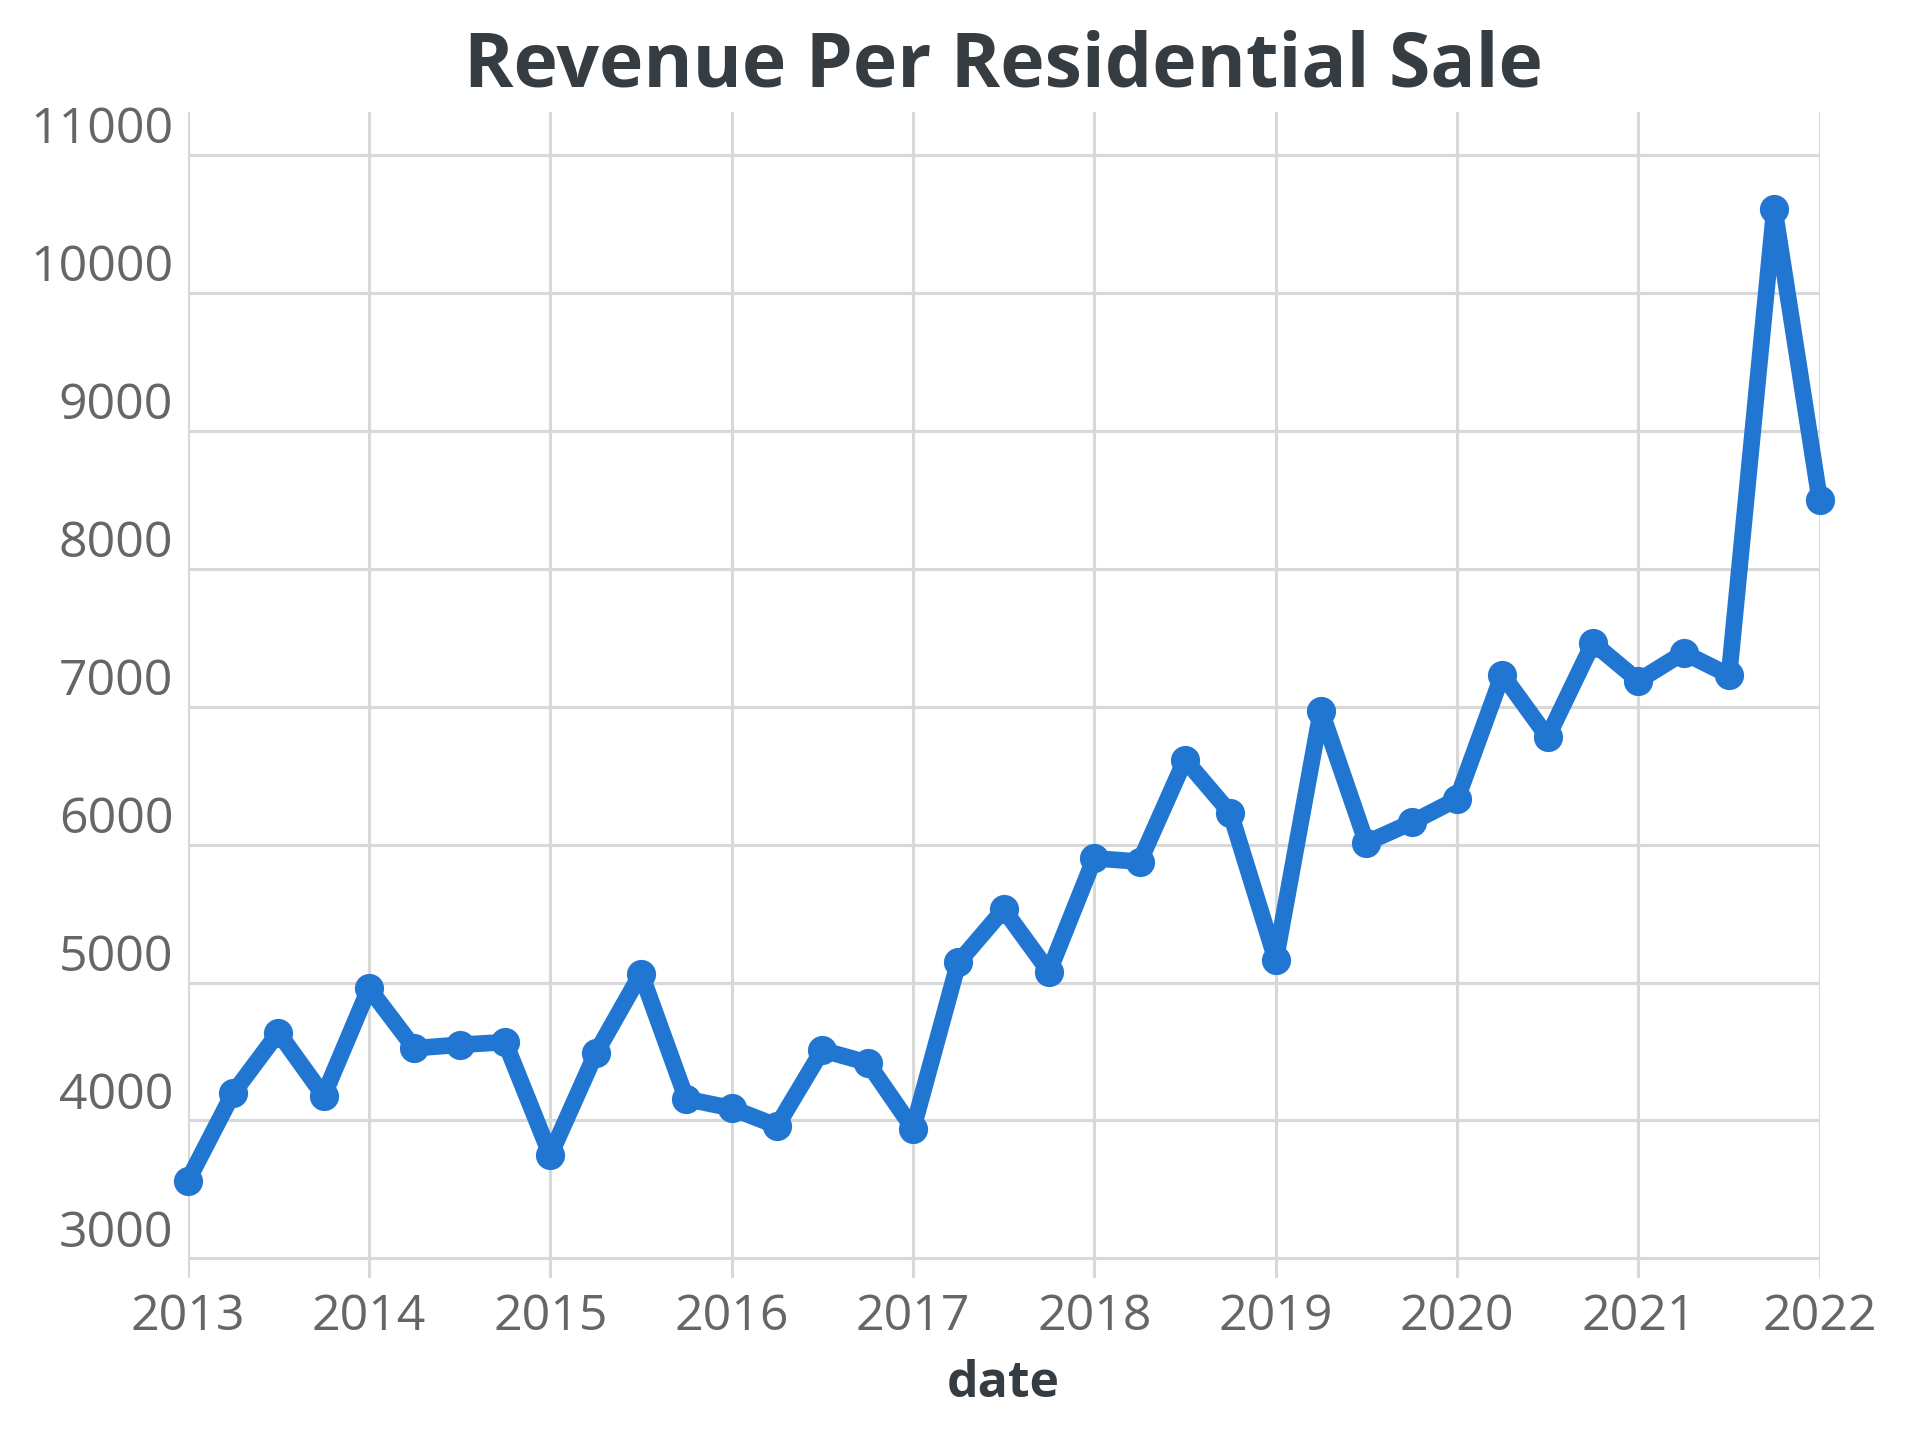

In [493]:
with plt.style.context(get_theme()):
    ax = res.plot(
        x="date", y="total_per_record", legend=False, clip_on=False, marker="o"
    )
    ax.set_title("Revenue Per Residential Sale")

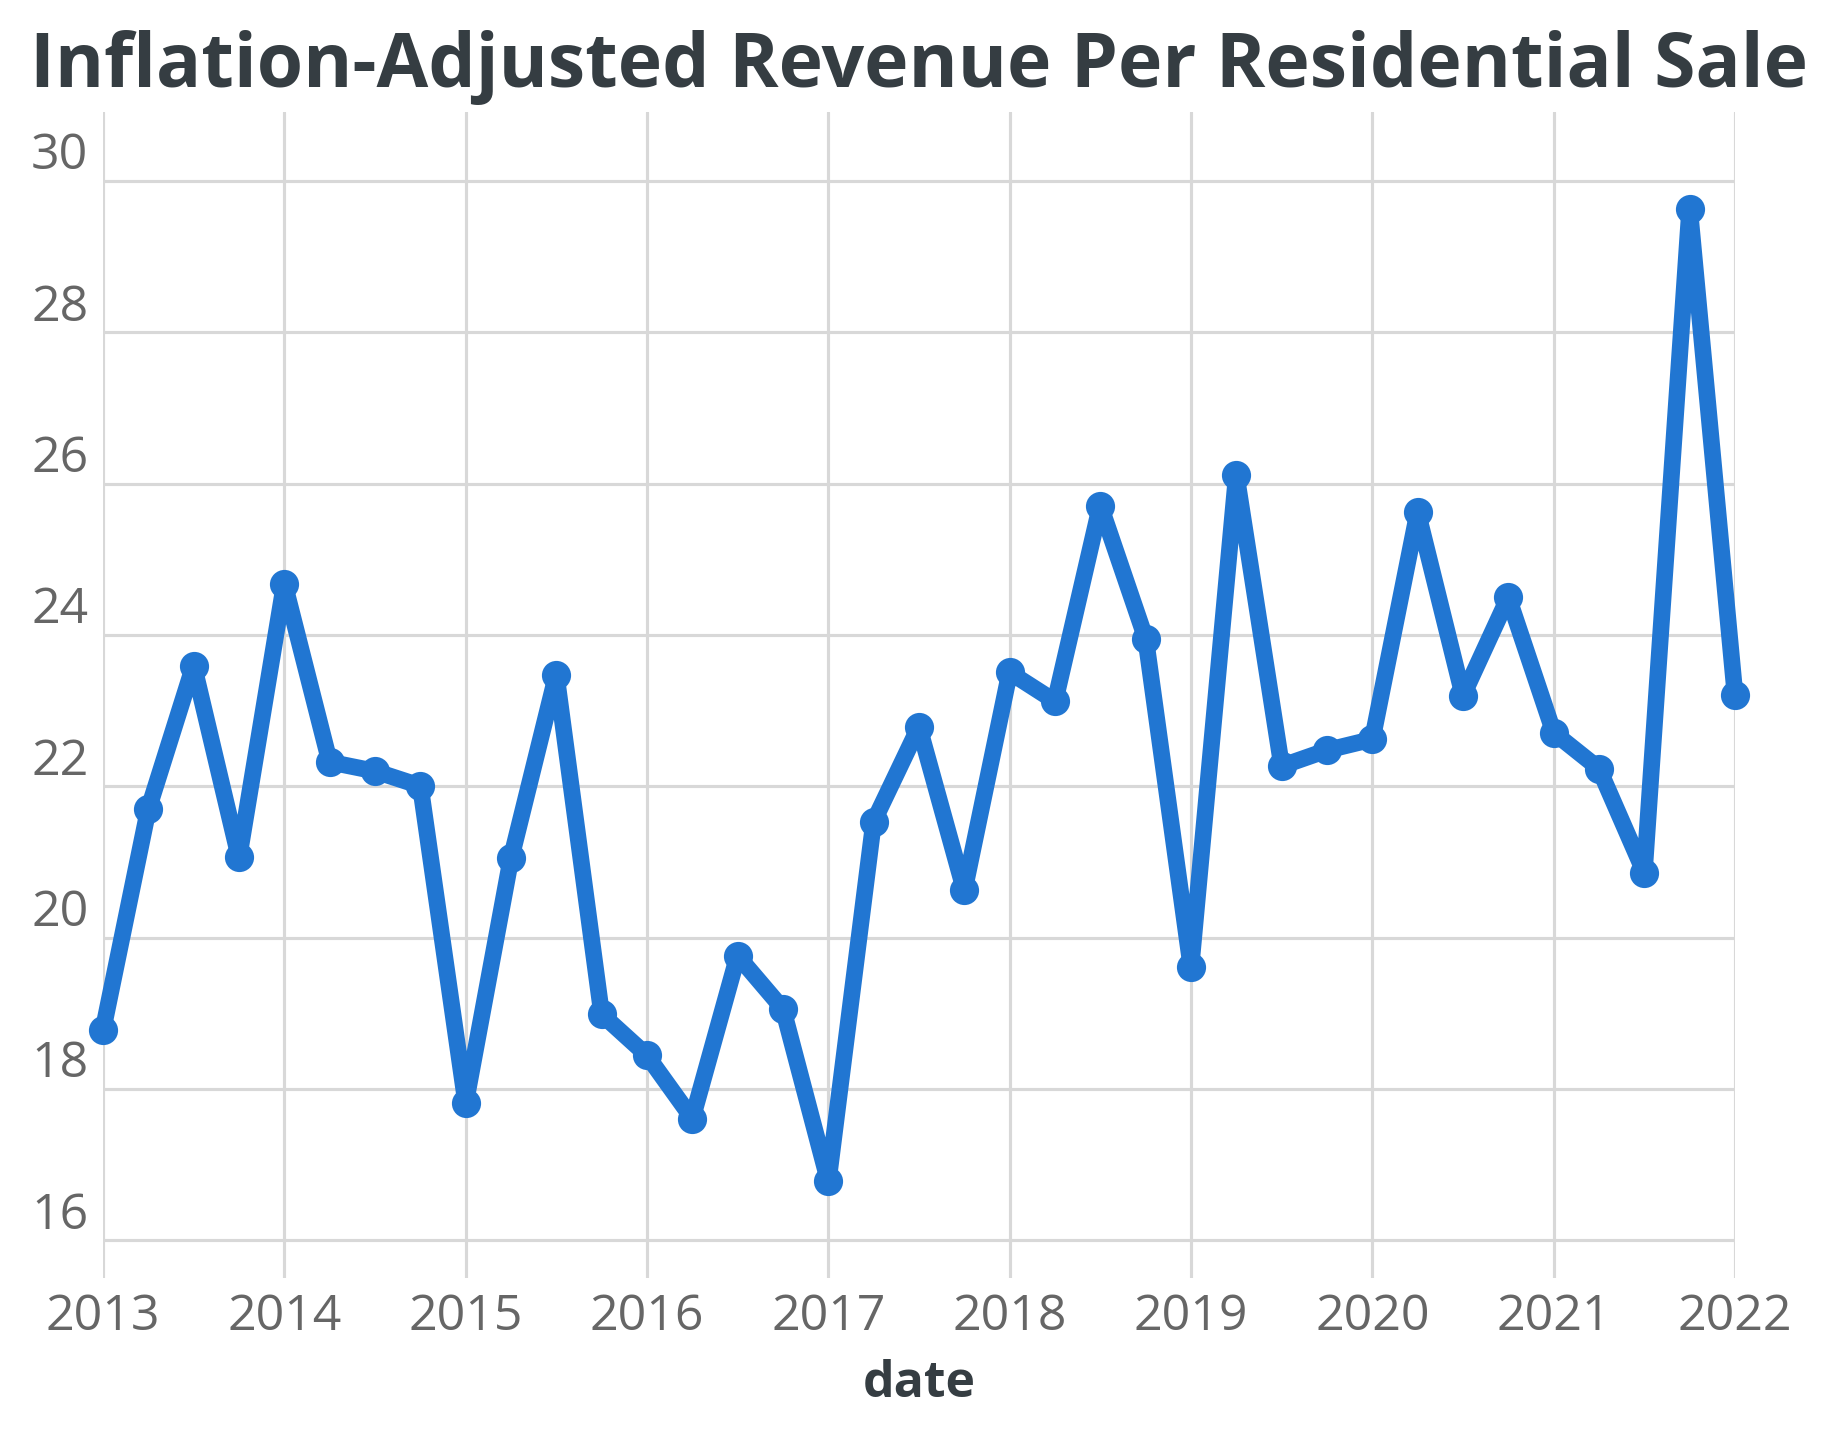

In [494]:
X = (res.set_index("date")["total_per_record"] / HPI).dropna()

with plt.style.context(get_theme()):
    ax = X.plot(legend=False, clip_on=False, marker="o")
    ax.set_title("Inflation-Adjusted Revenue Per Residential Sale")

### Non-residential

#### Number of sales

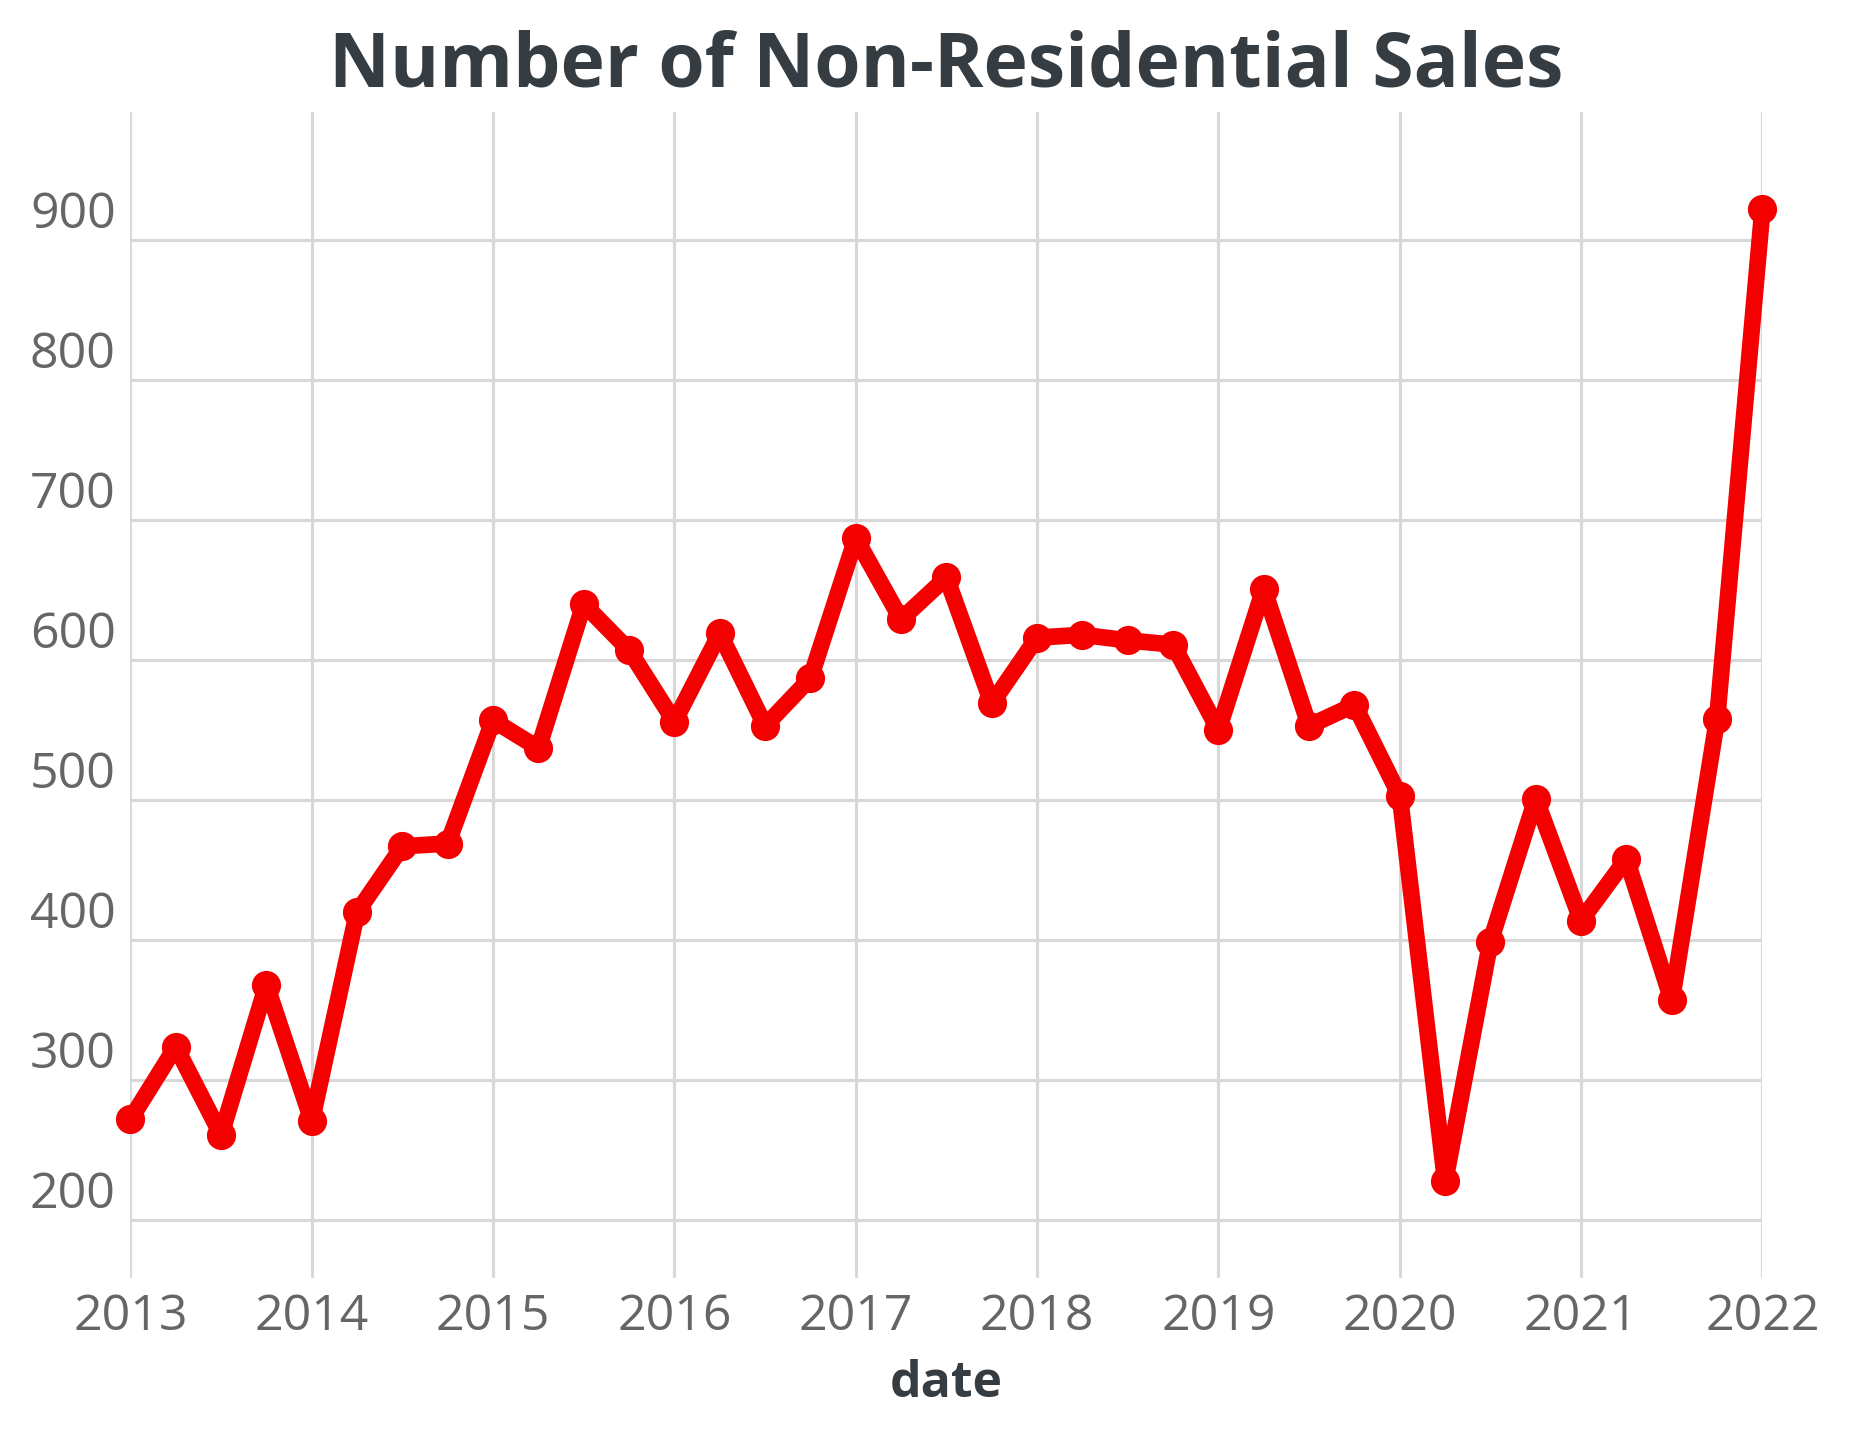

In [442]:
with plt.style.context(get_theme()):
    ax = nonres.plot(
        x="date",
        y="num_records",
        color=palette["red"],
        legend=False,
        clip_on=False,
        marker="o",
    )
    ax.set_title("Number of Non-Residential Sales")

#### Total Per Sale

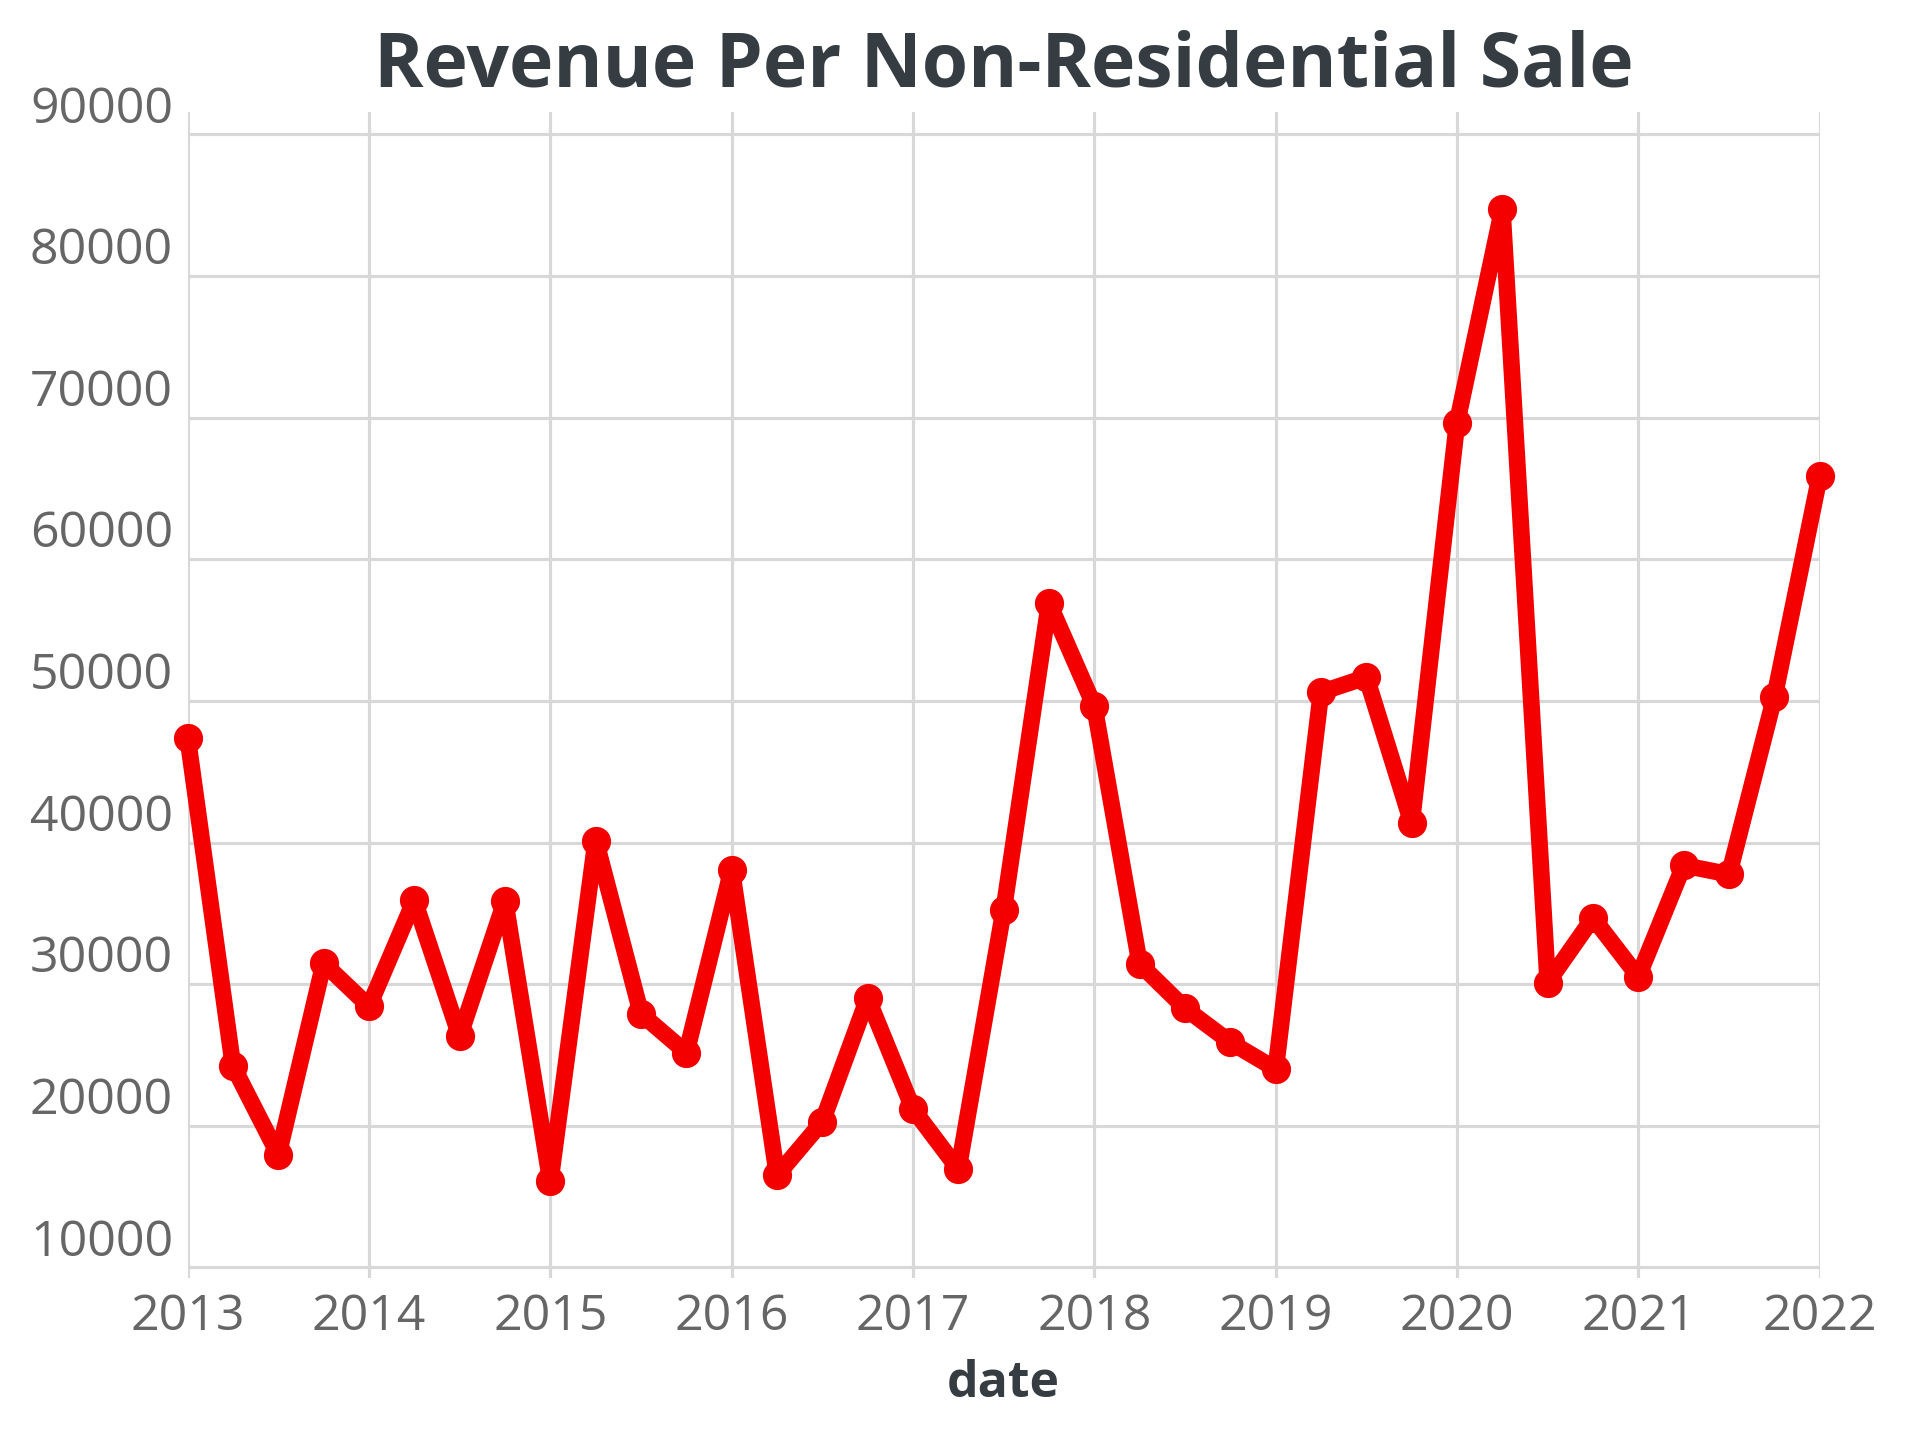

In [24]:
with plt.style.context(get_theme()):
    ax = nonres.plot(
        x="date",
        y="total_per_record",
        color=palette["red"],
        legend=False,
        clip_on=False,
        marker="o",
    )
    ax.set_title("Revenue Per Non-Residential Sale")

## 3. Analysis

In [42]:
def get_forecast_df(start_date="2018-01-01", end_date="2027-06-30"):
    FORECAST = pd.DataFrame(
        columns=[
            "res_sales",
            "res_price_per_sale",
            "nonres_sales",
            "nonres_price_per_sale",
        ],
        index=pd.date_range(start_date, end_date, freq="QS"),
    )

    for i, df in enumerate([res, nonres]):
        if i == 0:
            cols = [
                ("res_sales", "num_records"),
                ("res_price_per_sale", "total_per_record"),
            ]
        else:
            cols = [
                ("nonres_sales", "num_records"),
                ("nonres_price_per_sale", "total_per_record"),
            ]
        for (a, b) in cols:

            ii = df.index.intersection(FORECAST.index)
            FORECAST.loc[ii, a] = df.loc[ii, b]

    return FORECAST

In [44]:
forecast = get_forecast_df()

### Project residential sales

In [103]:
# Moderate
# 2020 is a scaled down version of 2019
MODERATE.loc["2021", "res_sales"] = MODERATE.loc["2019", "res_sales"].values * [
    0.95,
    0.95,
    0.95,
    0.95,
]
MODERATE.loc["2022", "res_sales"] = MODERATE.loc["2019", "res_sales"].values[:2] * 1.0

In [104]:
# Severe
# 2020 is a scaled down version of 2019
SEVERE.loc["2021", "res_sales"] = SEVERE.loc["2019", "res_sales"].values * [
    0.85,
    0.85,
    0.9,
    0.9,
]
SEVERE.loc["2022", "res_sales"] = SEVERE.loc["2019", "res_sales"].values[:2] * 0.95

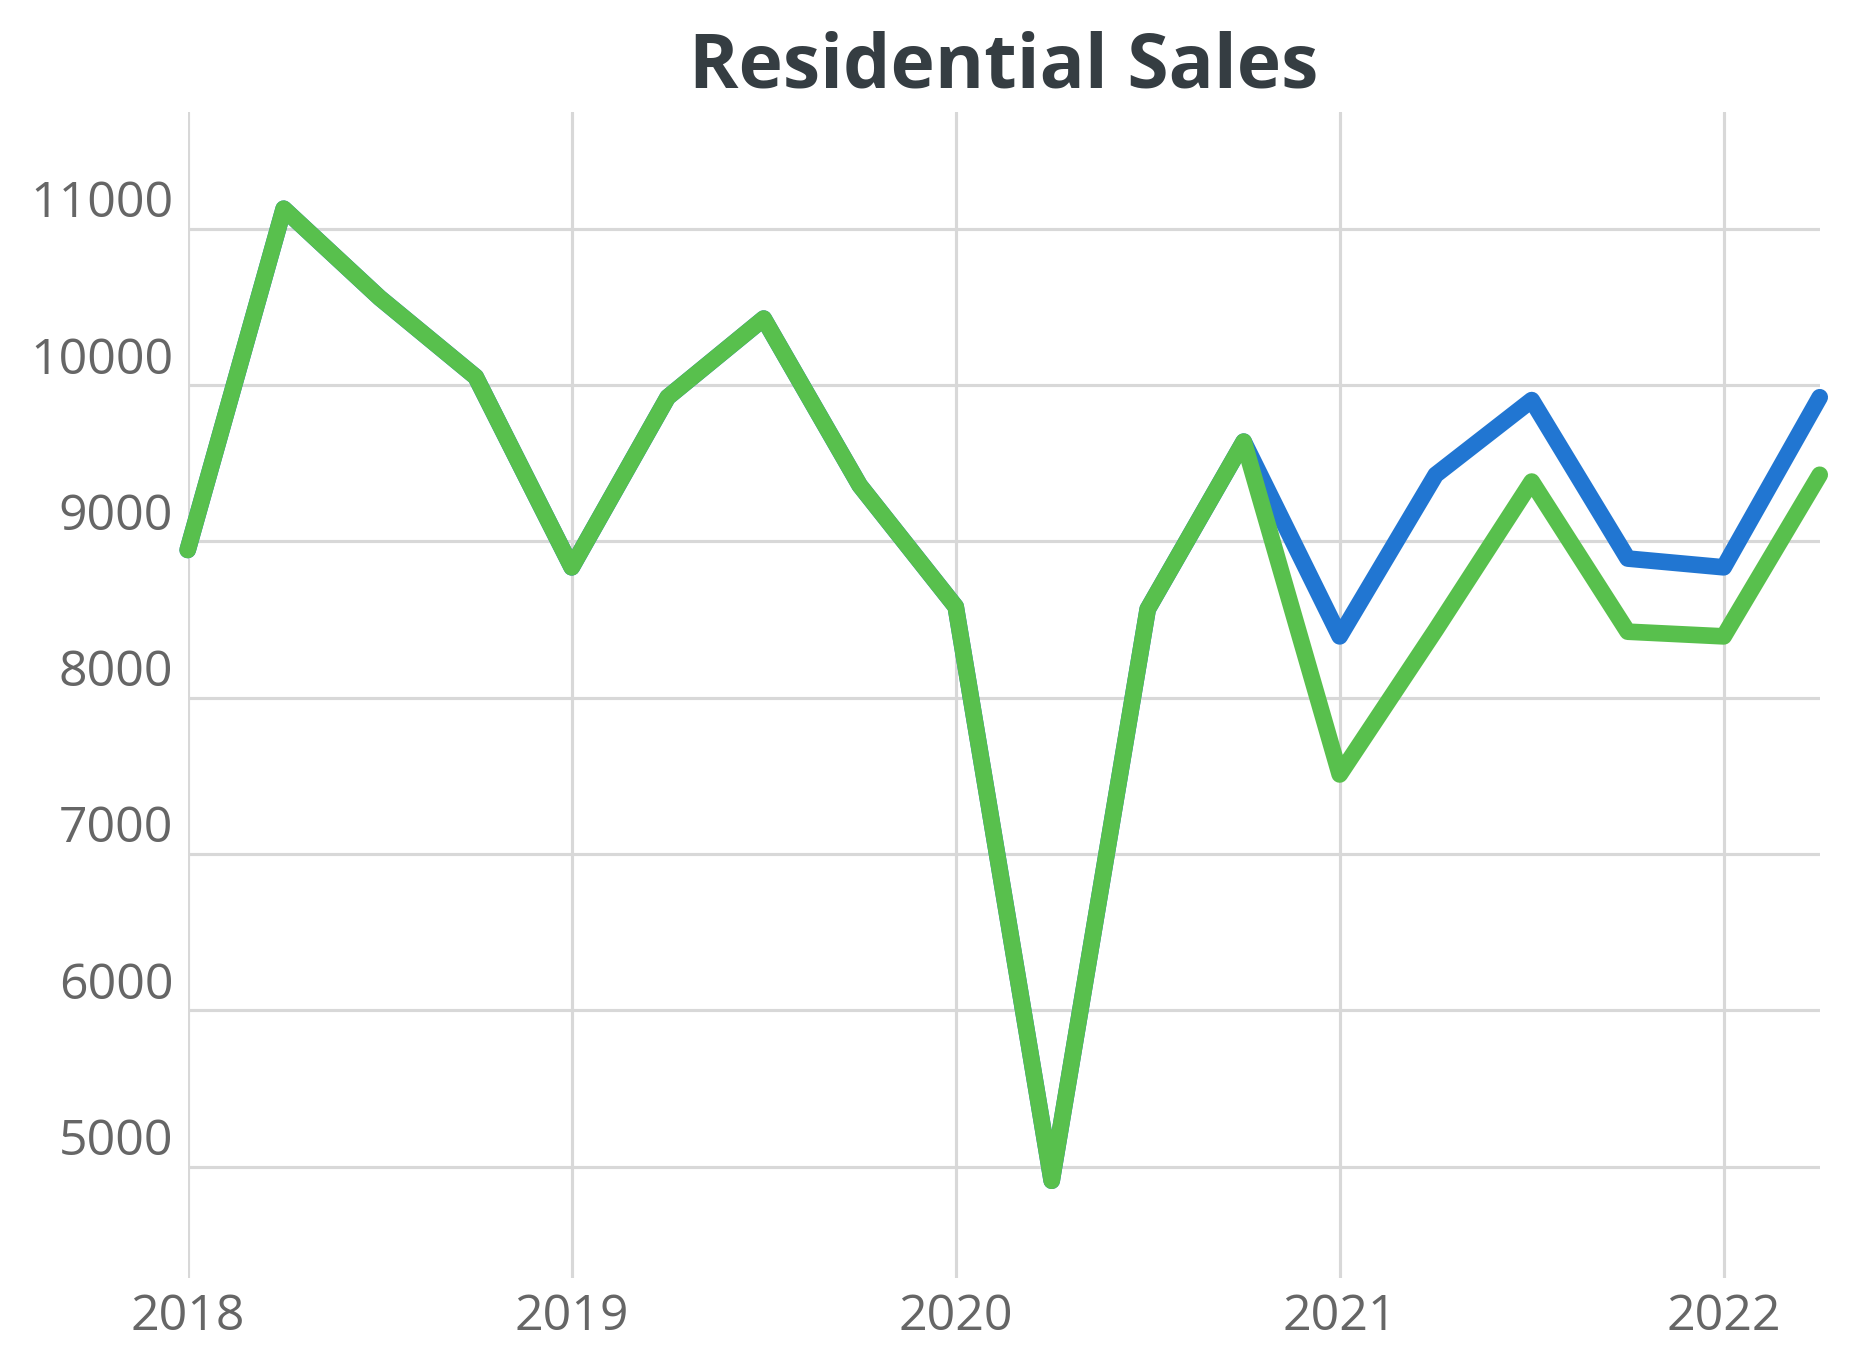

In [105]:
with plt.style.context(get_theme()):

    ax = MODERATE["res_sales"].plot(clip_on=False)
    ax = SEVERE["res_sales"].plot(clip_on=False)
    ax.set_title("Residential Sales")

### Project nonresidential sales

In [106]:
# Moderate
start = MODERATE.loc["2020-10", "nonres_sales"].squeeze()
growth = np.cumprod(
    np.concatenate(
        [
            [start],
            [
                1.02,
                1.02,
                1.01,
                1.01,
                1.01,
                1.01,
            ],
        ]
    )
)

MODERATE.loc["2021":, "nonres_sales"] = growth[1:]

In [107]:
# Severe
start = SEVERE.loc["2020-10", "nonres_sales"].squeeze()
growth = np.cumprod(
    np.concatenate(
        [
            [0.9 * start],
            [
                1.02,
                1.02,
                1.03,
                1.03,
                1.02,
                1.02,
            ],
        ]
    )
)

SEVERE.loc["2021":, "nonres_sales"] = growth[1:]

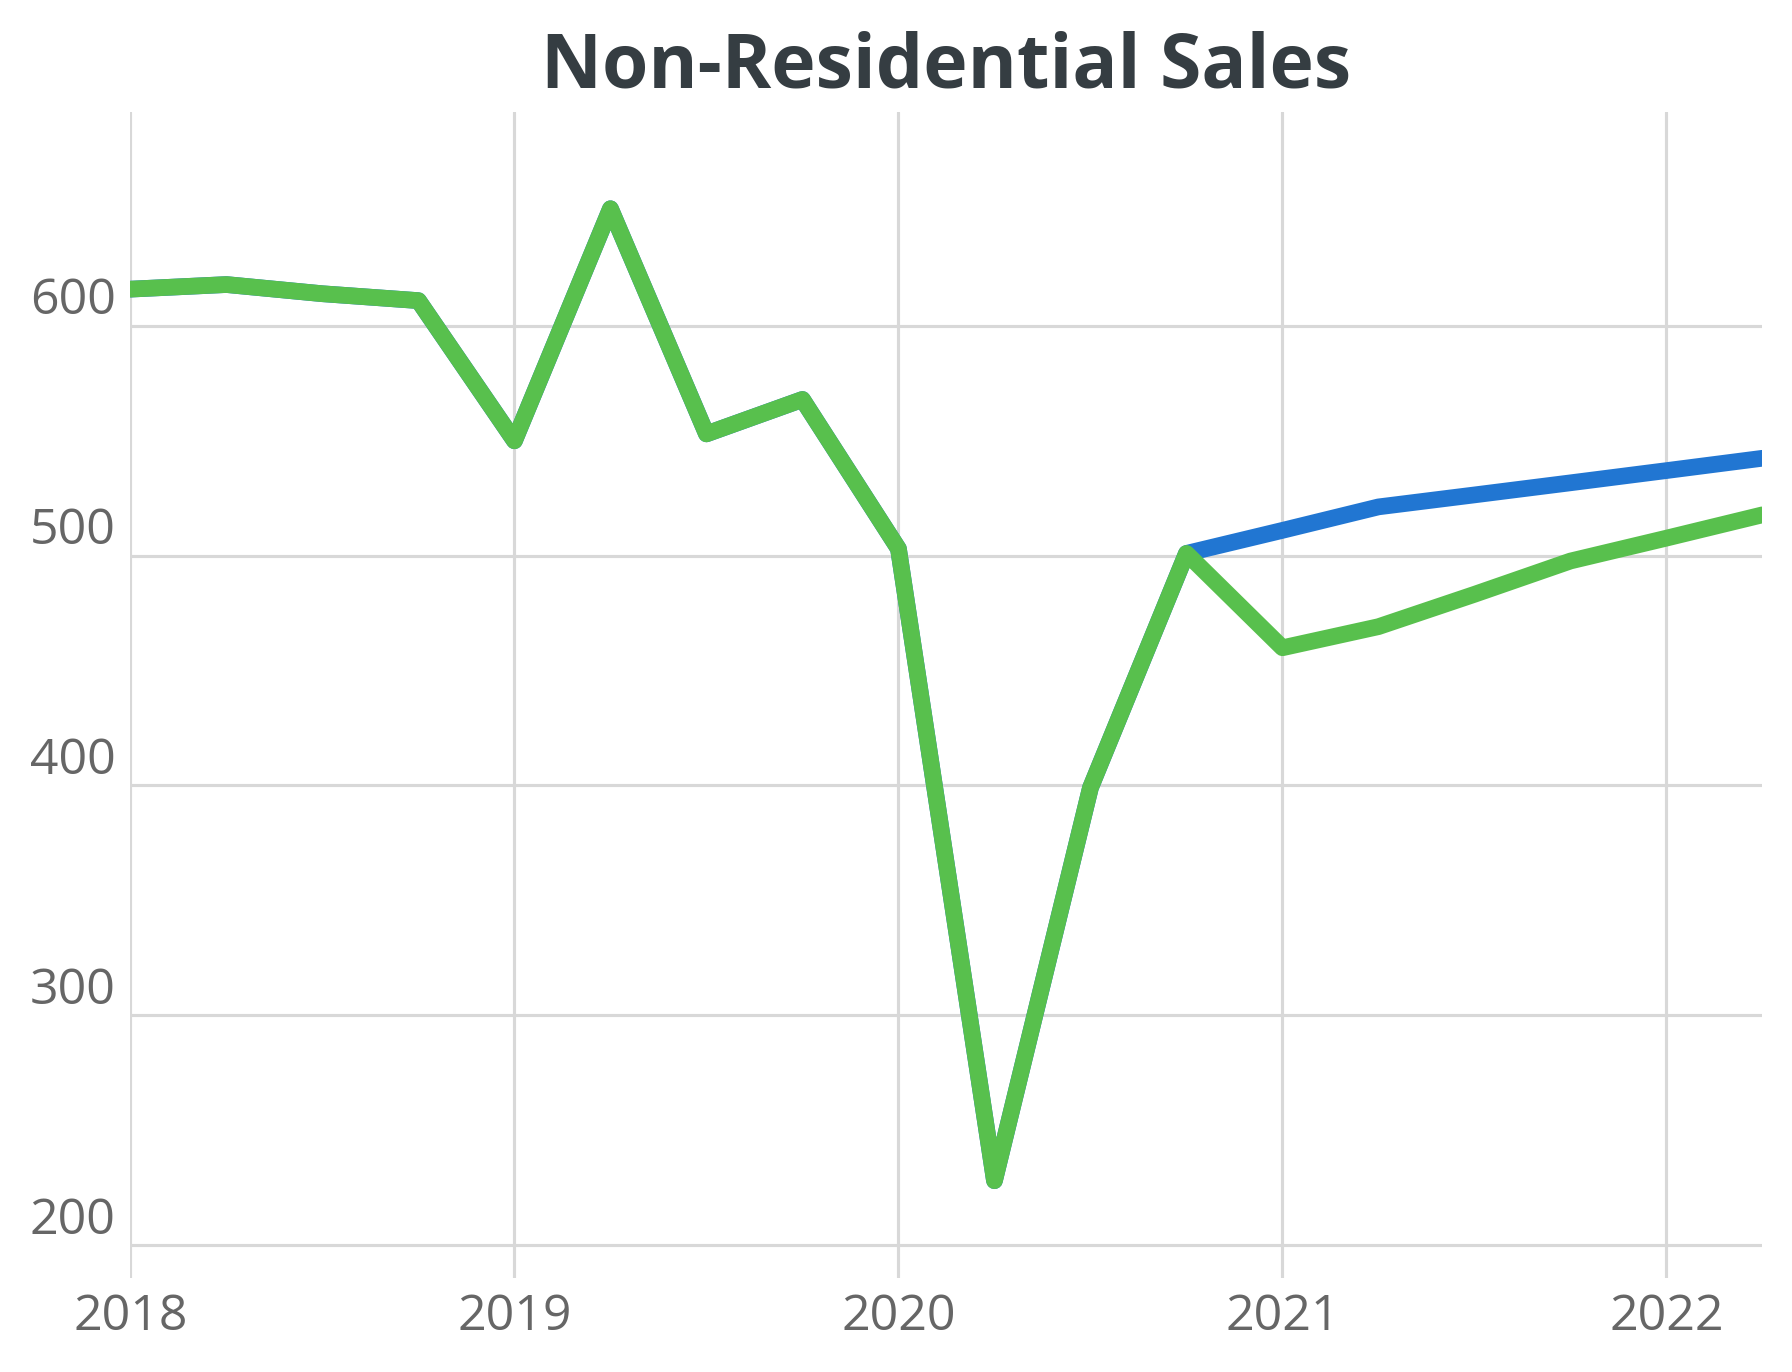

In [108]:
with plt.style.context(get_theme()):

    ax = MODERATE["nonres_sales"].plot()
    ax = SEVERE["nonres_sales"].plot()
    ax.set_title("Non-Residential Sales")

### Project residential price / sale

Residential growth in 2019 for price/sale:

In [109]:
(
    MODERATE.loc["2020-10-01", "res_price_per_sale"]
    / MODERATE.loc["2019-10-01", "res_price_per_sale"]
) ** (1 / 4) - 1

0.049095767700839454

In [111]:
# Moderate
growth_rate = 0.02
MODERATE.loc["2021":, "res_price_per_sale"] = (
    MODERATE.loc["2020", "res_price_per_sale"].mean()
    * (np.ones(6) * (1 + growth_rate)).cumprod()
)

In [112]:
# Severe
growth_rate = 0.005
SEVERE.loc["2021":, "res_price_per_sale"] = (
    SEVERE.loc["2020", "res_price_per_sale"].mean()
    * (np.ones(6) * (1 + growth_rate)).cumprod()
)

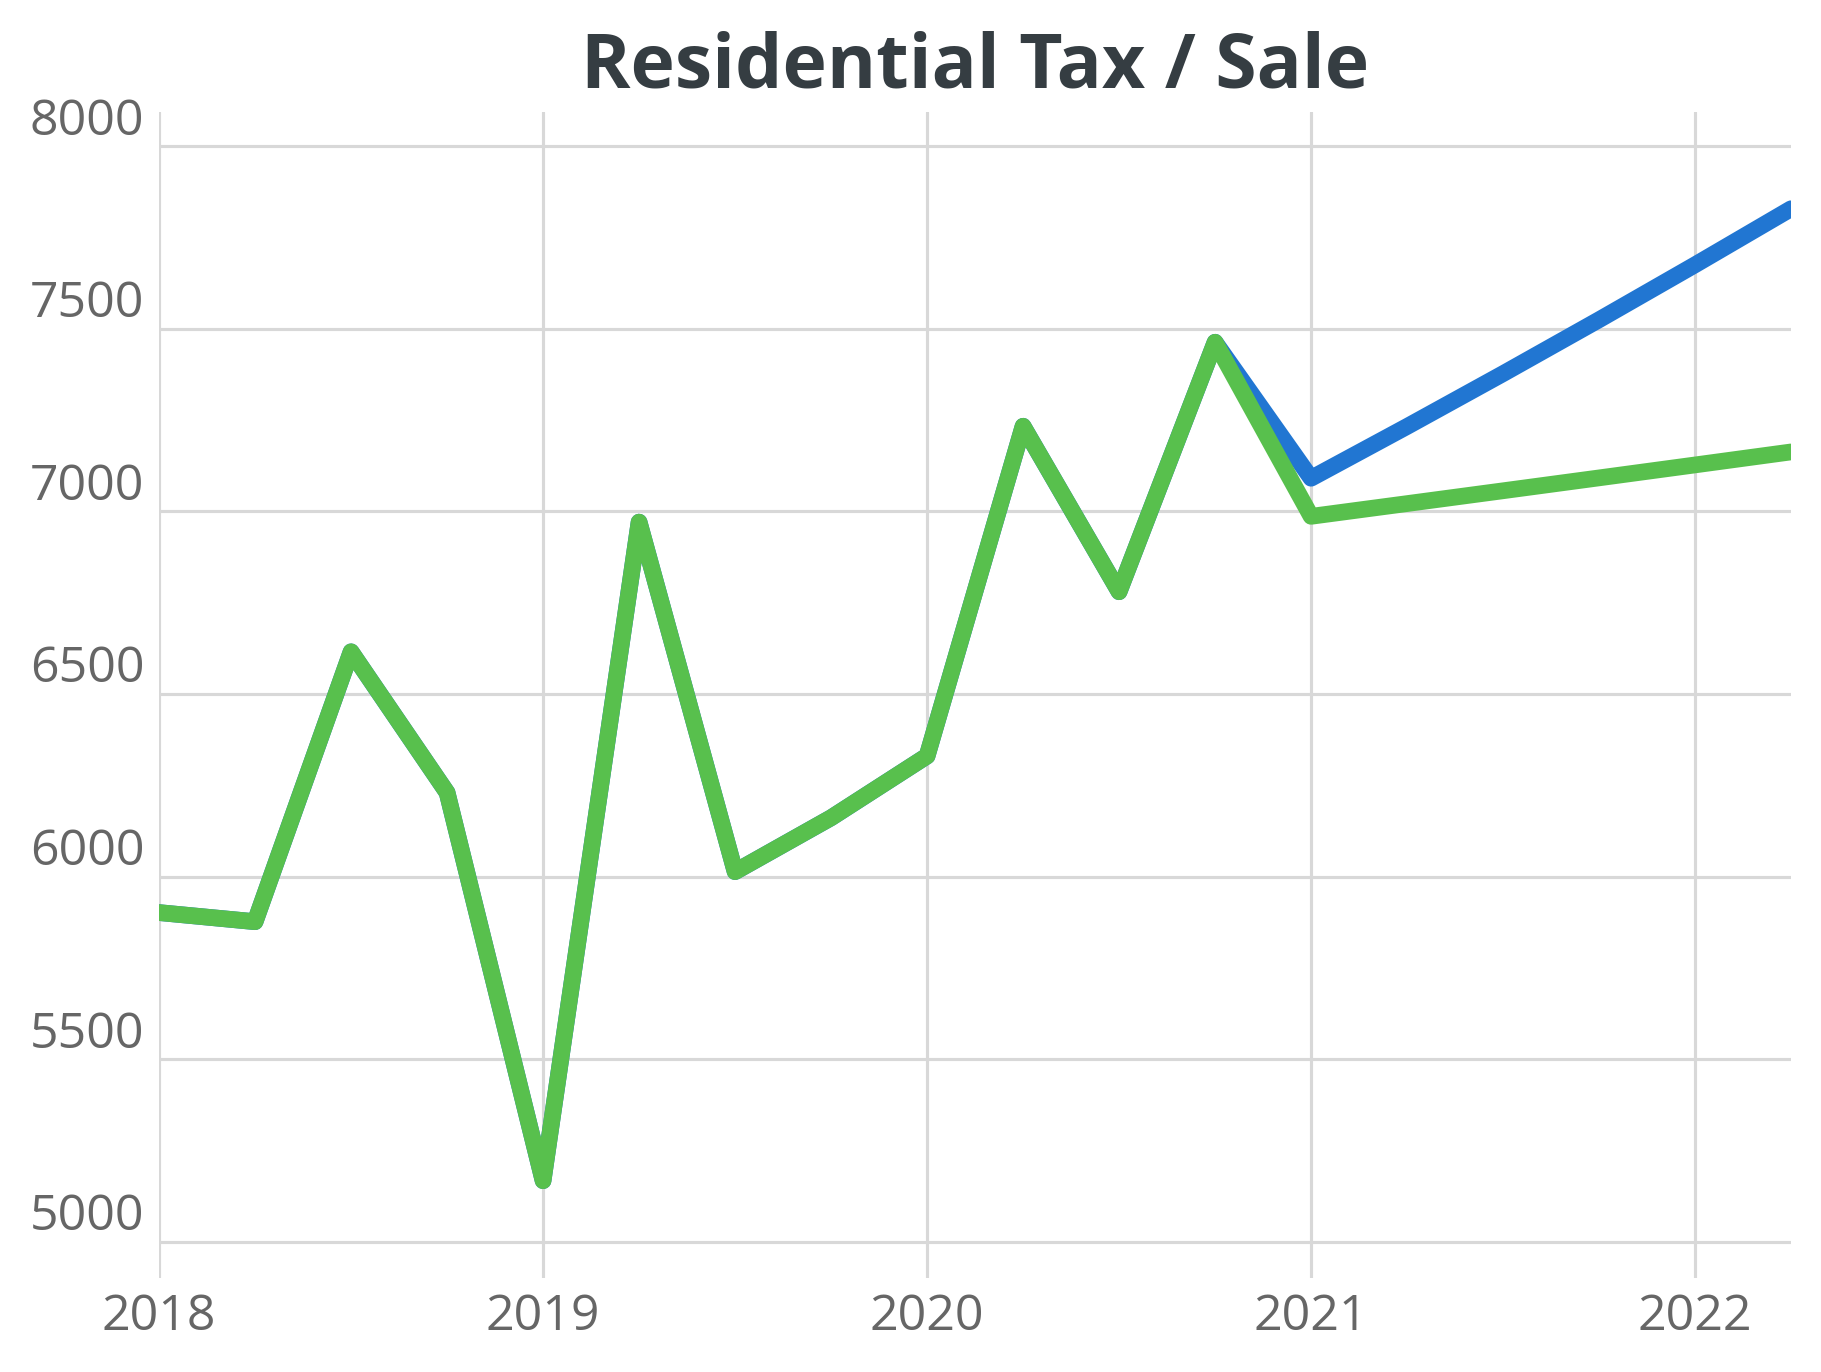

In [113]:
with plt.style.context(get_theme()):

    ax = MODERATE["res_price_per_sale"].plot()
    ax = SEVERE["res_price_per_sale"].plot(ax=ax)
    ax.set_title("Residential Tax / Sale")

### Project nonresidential price / sale

In [114]:
(
    MODERATE.loc["2020-10-01", "nonres_price_per_sale"]
    / MODERATE.loc["2019-10-01", "nonres_price_per_sale"]
) ** (1 / 4) - 1

-0.043099401581882635

In [115]:
# Moderate
start = MODERATE.loc["2020-10", "nonres_price_per_sale"].squeeze()
growth = np.cumprod(
    np.concatenate(
        [
            [0.9 * start],
            [
                1.03,
                1.02,
                1.02,
                1.02,
                1.01,
                1.01,
            ],
        ]
    )
)

MODERATE.loc["2021":, "nonres_price_per_sale"] = growth[1:]

In [116]:
# Severe
start = SEVERE.loc["2020-10", "nonres_price_per_sale"].squeeze()
growth = np.cumprod(
    np.concatenate(
        [
            [0.8 * start],
            [
                1.02,
                1.02,
                1.02,
                1.02,
                1.01,
                1.01,
            ],
        ]
    )
)

SEVERE.loc["2021":, "nonres_price_per_sale"] = growth[1:]

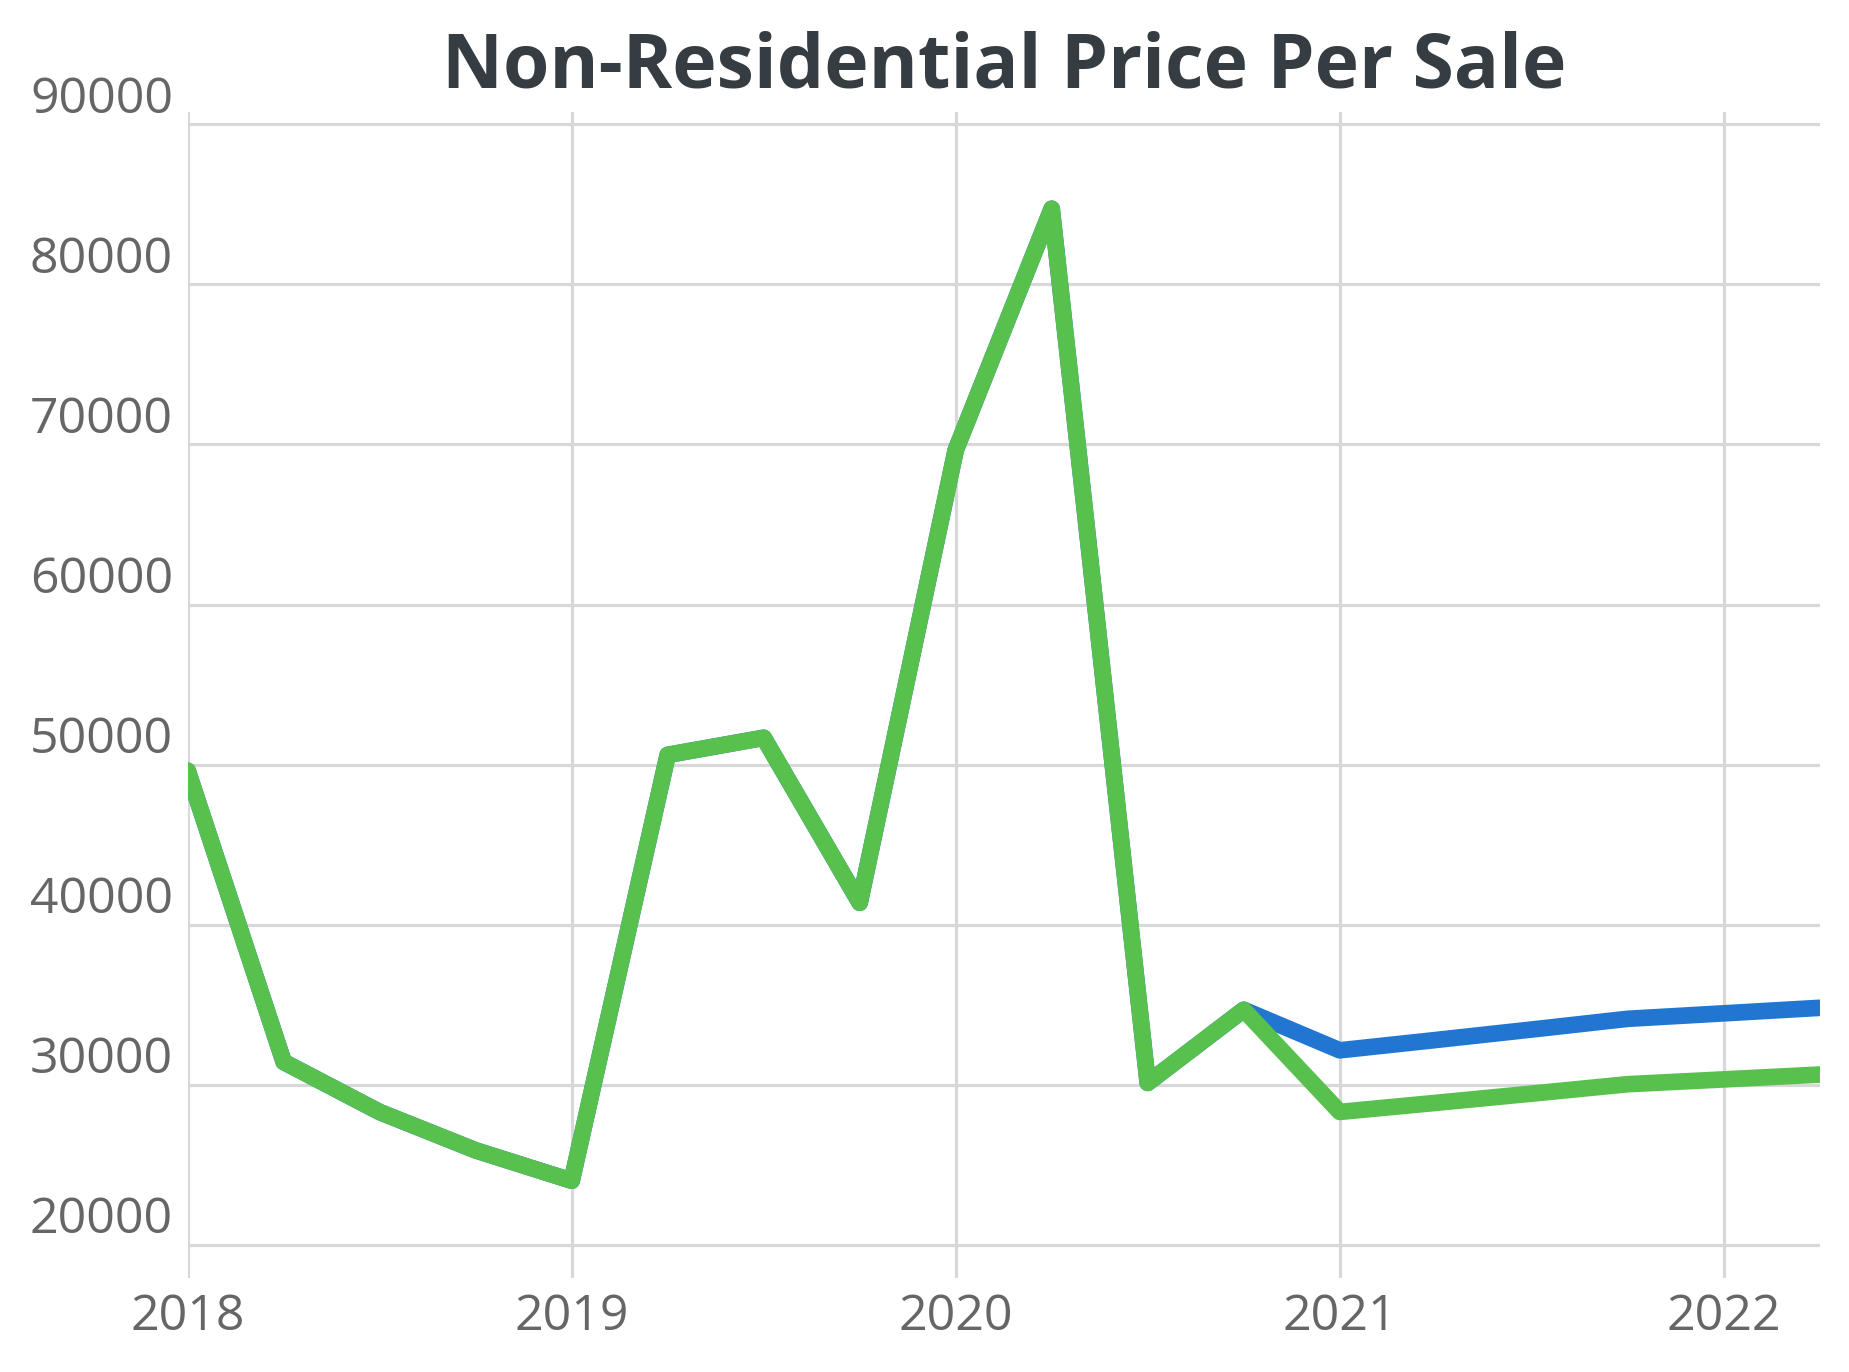

In [117]:
with plt.style.context(get_theme()):

    ax = MODERATE["nonres_price_per_sale"].plot()
    ax = SEVERE["nonres_price_per_sale"].plot(ax=ax)
    ax.set_title("Non-Residential Price Per Sale")

## Get Combined Forecasts

In [118]:
def groupby_fiscal_year(df):
    X = df.copy()
    X.index = [get_fiscal_year(dt) for dt in X.index]
    X = X.reset_index()
    return X.groupby("index").sum().squeeze()

In [119]:
def get_nonresidential_forecast(df):
    return df["nonres_sales"] * df["nonres_price_per_sale"]

In [120]:
def get_residential_forecast(df):
    return df["res_sales"] * df["res_price_per_sale"]

In [121]:
def get_rtt_forecast(df):
    return get_residential_forecast(df) + get_nonresidential_forecast(df)

In [122]:
moderate_forecast = get_rtt_forecast(MODERATE)
severe_forecast = get_rtt_forecast(SEVERE)

In [123]:
groupby_fiscal_year(moderate_forecast) / 1e6

index
2018    168.162473
2019    326.620991
2020    316.605751
2021    320.595565
2022    358.563775
Name: 0, dtype: float64

In [124]:
groupby_fiscal_year(severe_forecast) / 1e6

index
2018    168.162473
2019    326.620991
2020    316.605751
2021    297.627009
2022    313.694559
Name: 0, dtype: float64

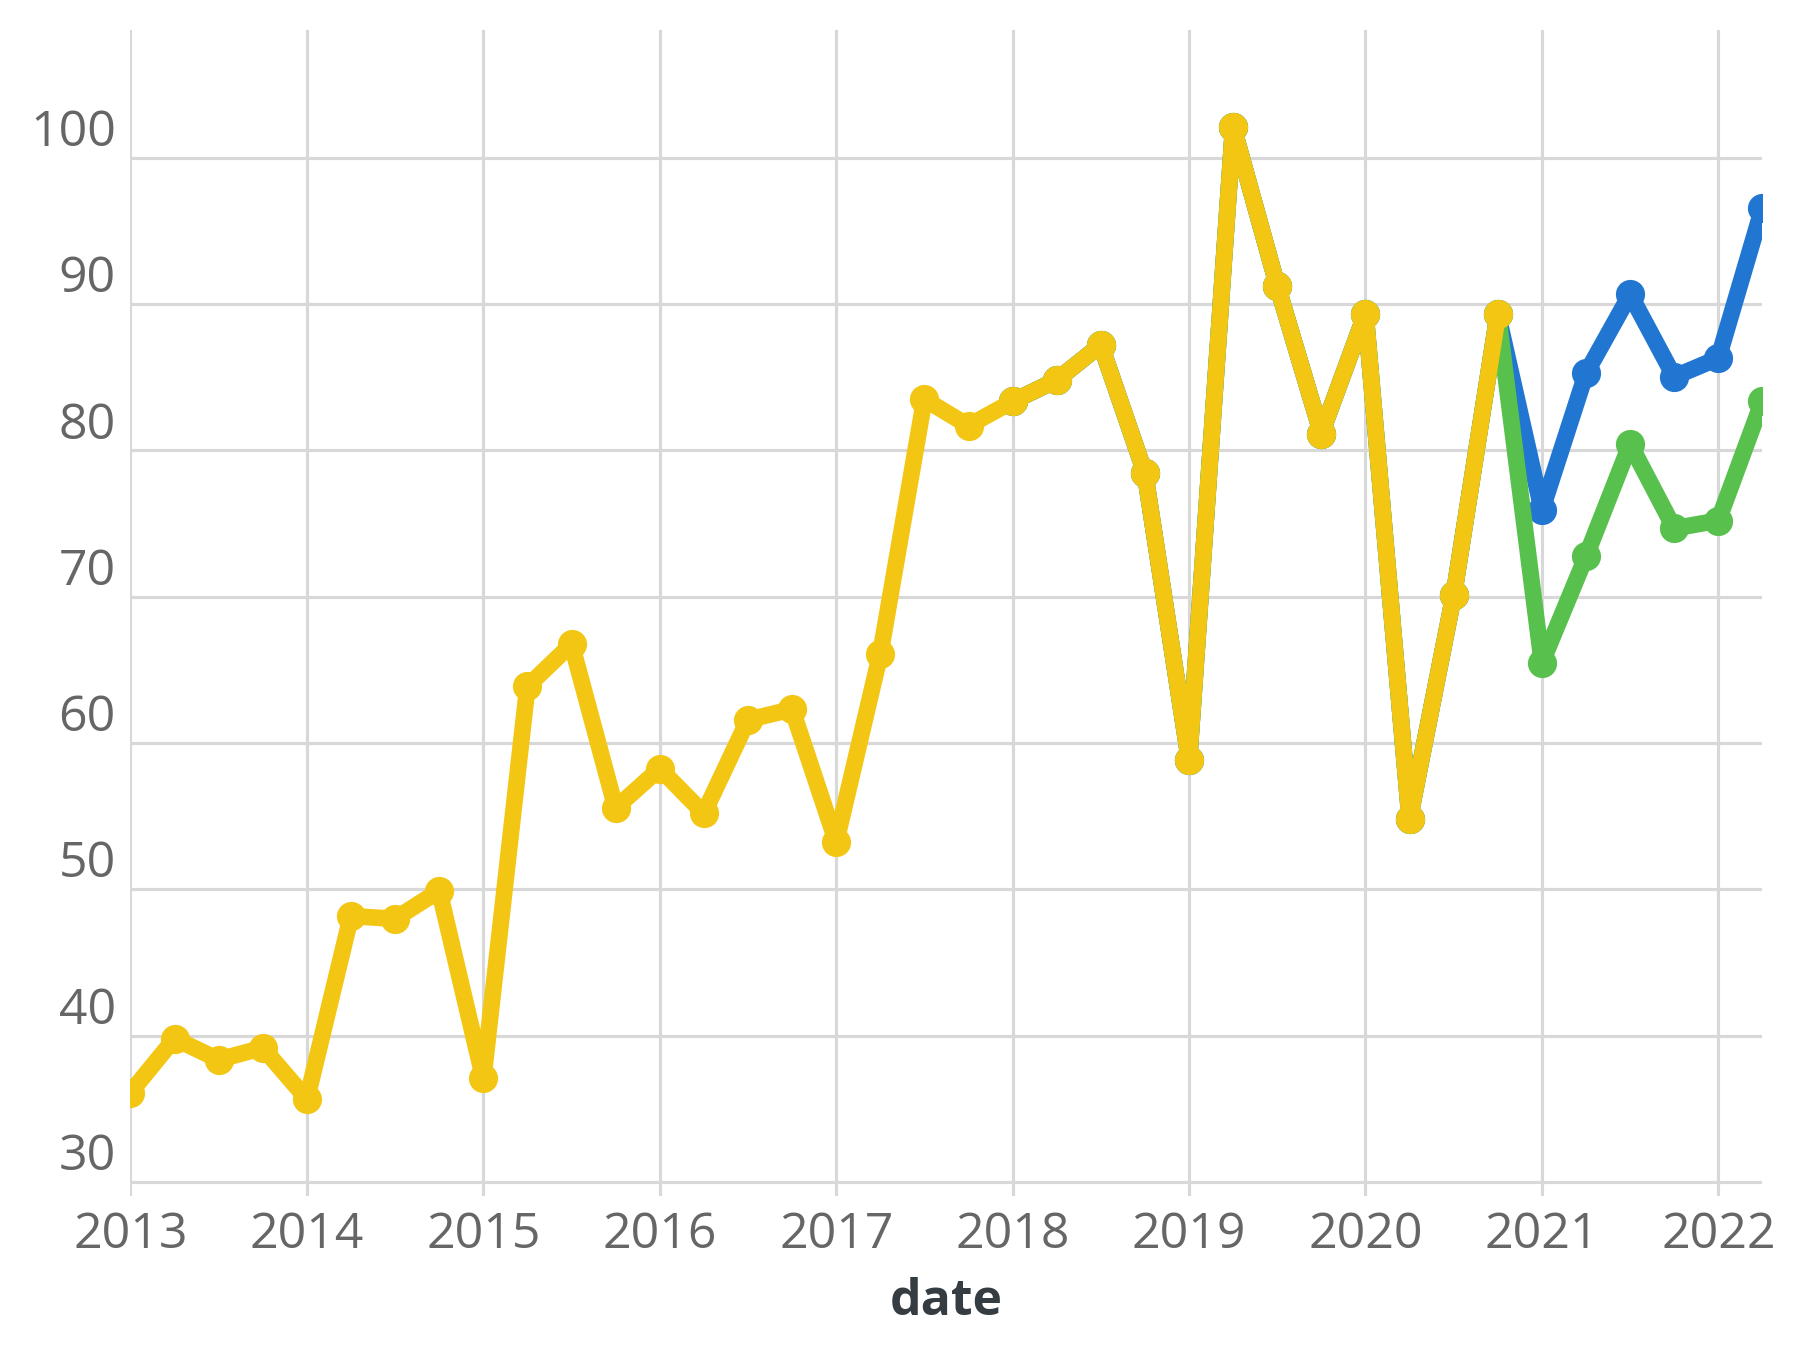

In [125]:
with plt.style.context(get_theme()):
    ax = (moderate_forecast / 1e6).plot(marker="o")
    ax = (severe_forecast / 1e6).plot(ax=ax, marker="o")
    agg_to_quarters(rtt_sectors.groupby("date")["total"].sum() / 1e6).plot(
        ax=ax, marker="o"
    )

## Final

In [126]:
out = {"moderate": {}, "severe": {}}

### Moderate

In [127]:
out["moderate"]["Residential"] = (
    get_residential_forecast(MODERATE).loc["2021":].tolist()
)

In [128]:
out["moderate"]["Non-Residential"] = (
    get_nonresidential_forecast(MODERATE).loc["2021":].tolist()
)

### Severe

In [129]:
out["severe"]["Residential"] = get_residential_forecast(SEVERE).loc["2021":].tolist()

In [130]:
out["severe"]["Non-Residential"] = (
    get_nonresidential_forecast(SEVERE).loc["2021":].tolist()
)

In [131]:
out

{'moderate': {'Residential': [59504922.23634641,
   68170250.75816274,
   73058693.95655346,
   66892750.42746627,
   67800043.69149524,
   77673338.7114734],
  'Non-Residential': [16430490.674820002,
   17094282.49808273,
   17610529.82952483,
   18142367.830376476,
   18507029.423767045,
   18879020.715184763]},
 'severe': {'Residential': [52458286.70835801,
   59213671.75955736,
   66204647.623281255,
   59725736.97083543,
   59811270.67657426,
   67513545.93516353],
  'Non-Residential': [13016777.078304004,
   13542654.872267488,
   14227913.208804224,
   14947845.61716972,
   15399270.554808244,
   15864328.525563456]}}

## Zillow Comparison

In [133]:
zillow = pd.read_csv(
    "../../data/rtt/County_zhvi_uc_sfrcondo_tier_0.33_0.67_sm_sa_mon.csv"
)

In [123]:
home_values = (
    zillow.query("RegionName == 'Philadelphia County'")
    .filter(regex="\d+", axis=1)
    .melt(value_name="price", var_name="date")
)

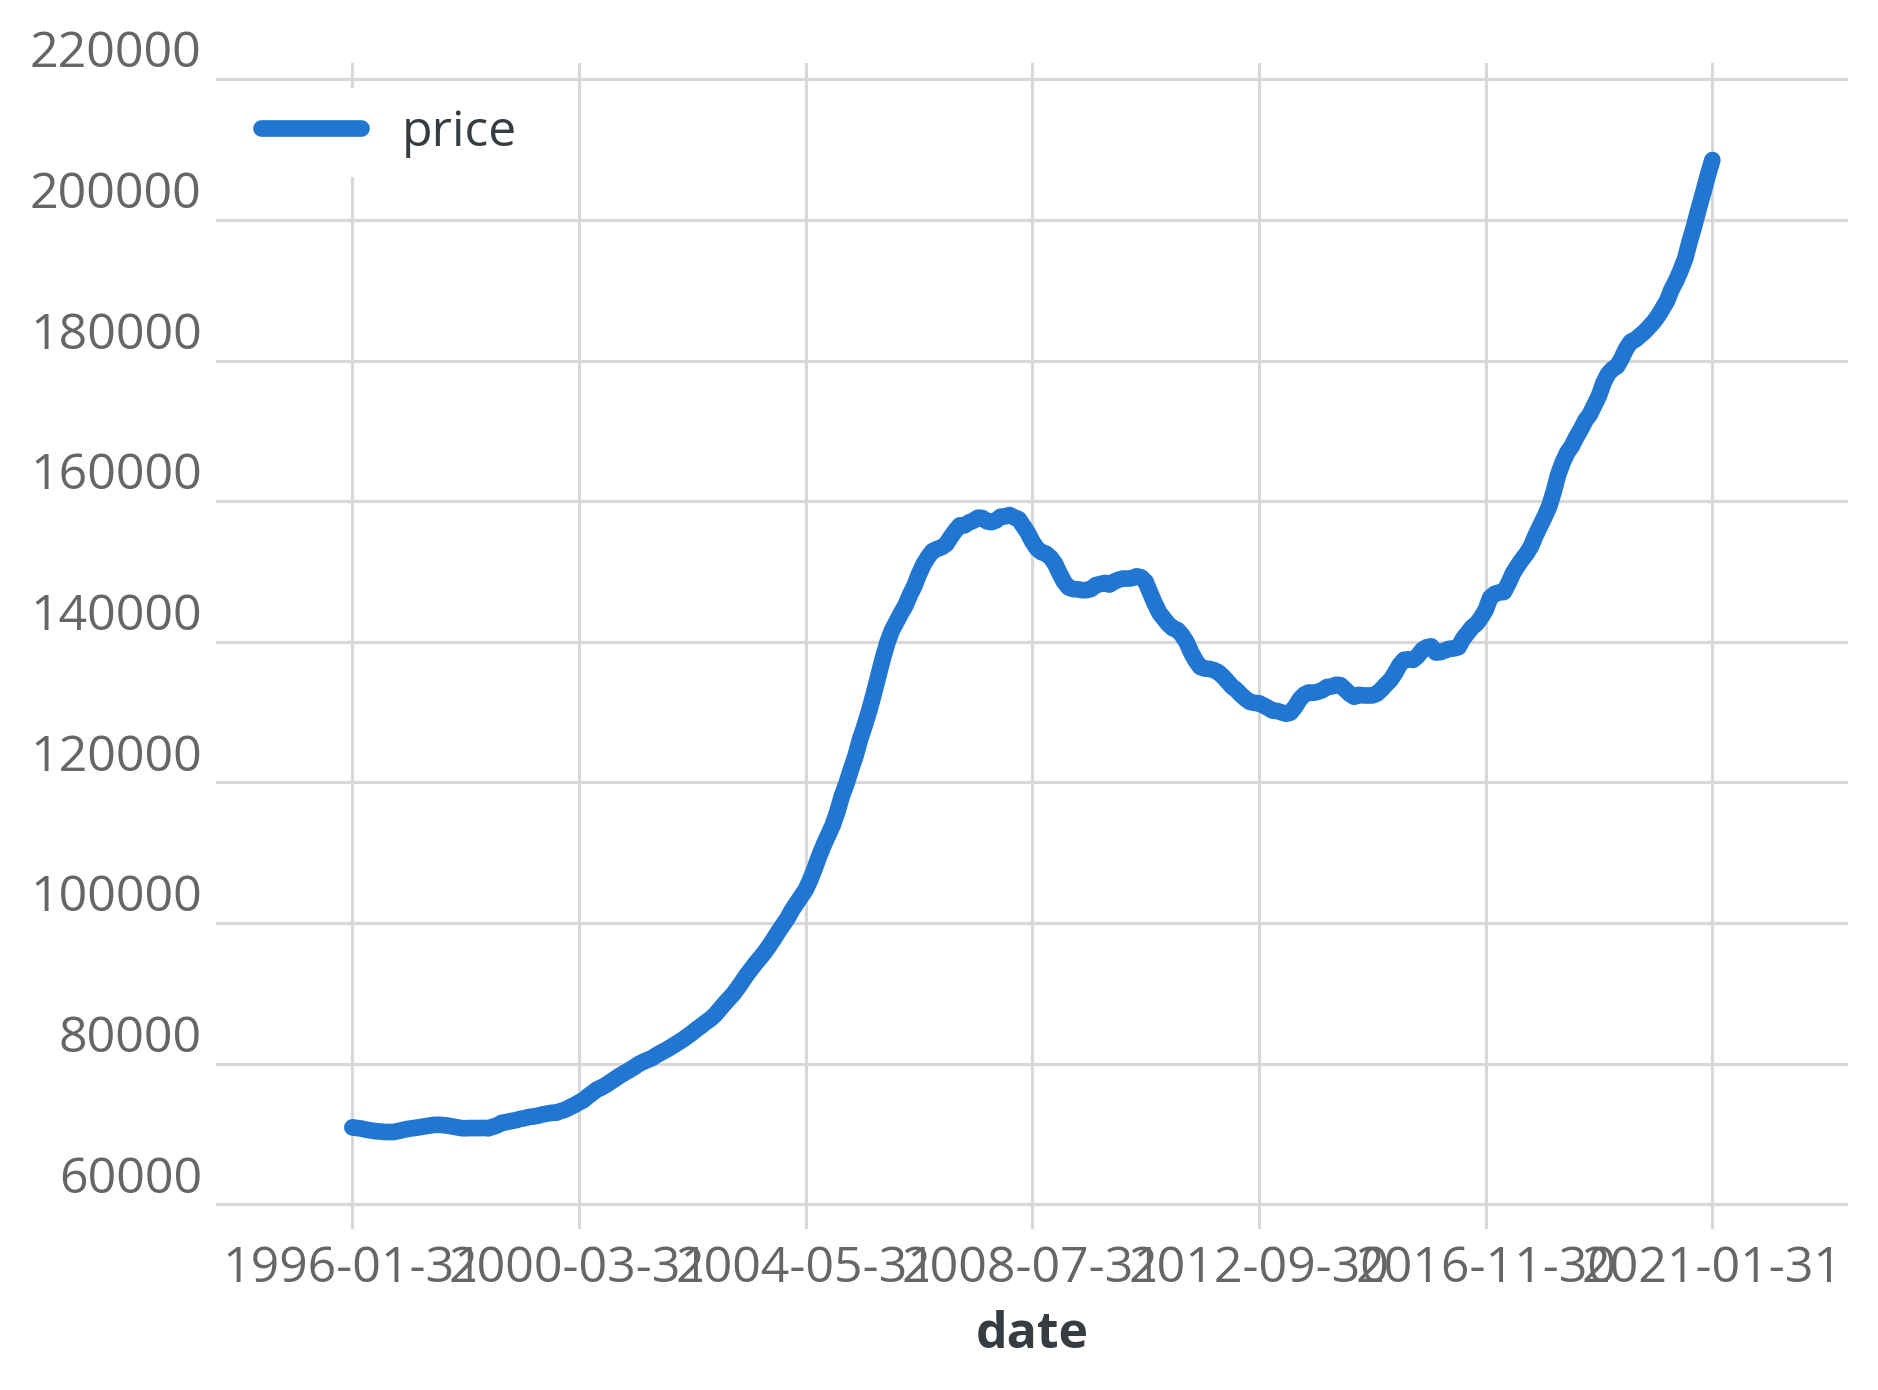

In [124]:
with plt.style.context(get_theme()):
    home_values.plot(x="date")

## V1

In [4]:
tax1 = v1(fresh=False)

In [5]:
moderate = tax1.run_forecast("moderate")
severe = tax1.run_forecast("severe")

In [6]:
actual = tax1.total_actuals
baseline = tax1.total_baseline

## Monthly

In [7]:
monthly_declines = (actual / baseline).dropna().loc["2020-03":]
monthly_declines

date
2020-03-01    1.274651
2020-04-01    0.773914
2020-05-01    0.492517
2020-06-01    0.398342
2020-07-01    0.890812
2020-08-01    0.770310
2020-09-01    1.003243
2020-10-01    1.027459
2020-11-01    1.089543
2020-12-01    1.319636
Name: total, dtype: float64

In [8]:
monthly_change_rate = monthly_declines.diff() / monthly_declines.shift()
monthly_change_rate

date
2020-03-01         NaN
2020-04-01   -0.392842
2020-05-01   -0.363603
2020-06-01   -0.191212
2020-07-01    1.236302
2020-08-01   -0.135272
2020-09-01    0.302387
2020-10-01    0.024138
2020-11-01    0.060425
2020-12-01    0.211183
Name: total, dtype: float64

## Quarterly

In [9]:
quarterly_declines = (
    (agg_to_quarters(actual) / agg_to_quarters(baseline)).dropna().loc["2020-03":]
)
quarterly_declines

date
2020-04-01    0.518993
2020-07-01    0.882292
2020-10-01    1.140416
Freq: QS-JAN, Name: total, dtype: float64

In [10]:
quarterly_change_rate = quarterly_declines.diff() / quarterly_declines.shift()
quarterly_change_rate

date
2020-04-01         NaN
2020-07-01    0.700008
2020-10-01    0.292560
Freq: QS-JAN, Name: total, dtype: float64

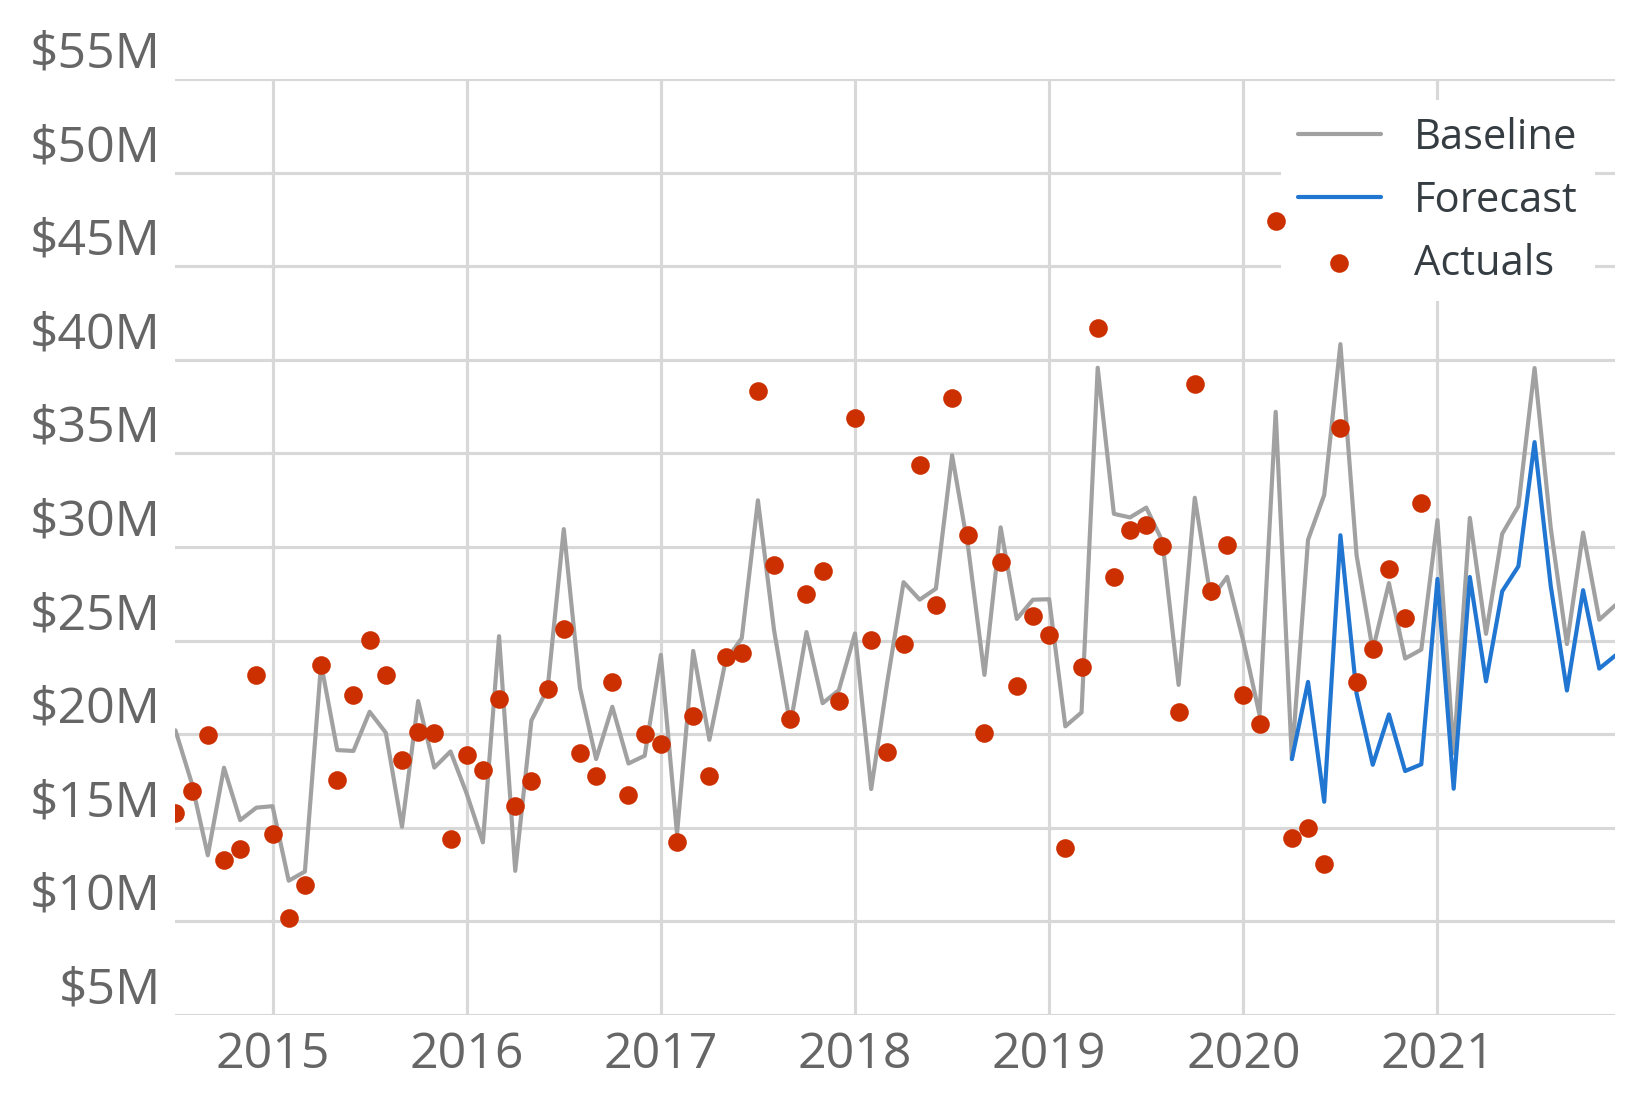

In [11]:
tax1.plot();

## V2

In [12]:
tax2 = v2(fresh=False)

### Moderate

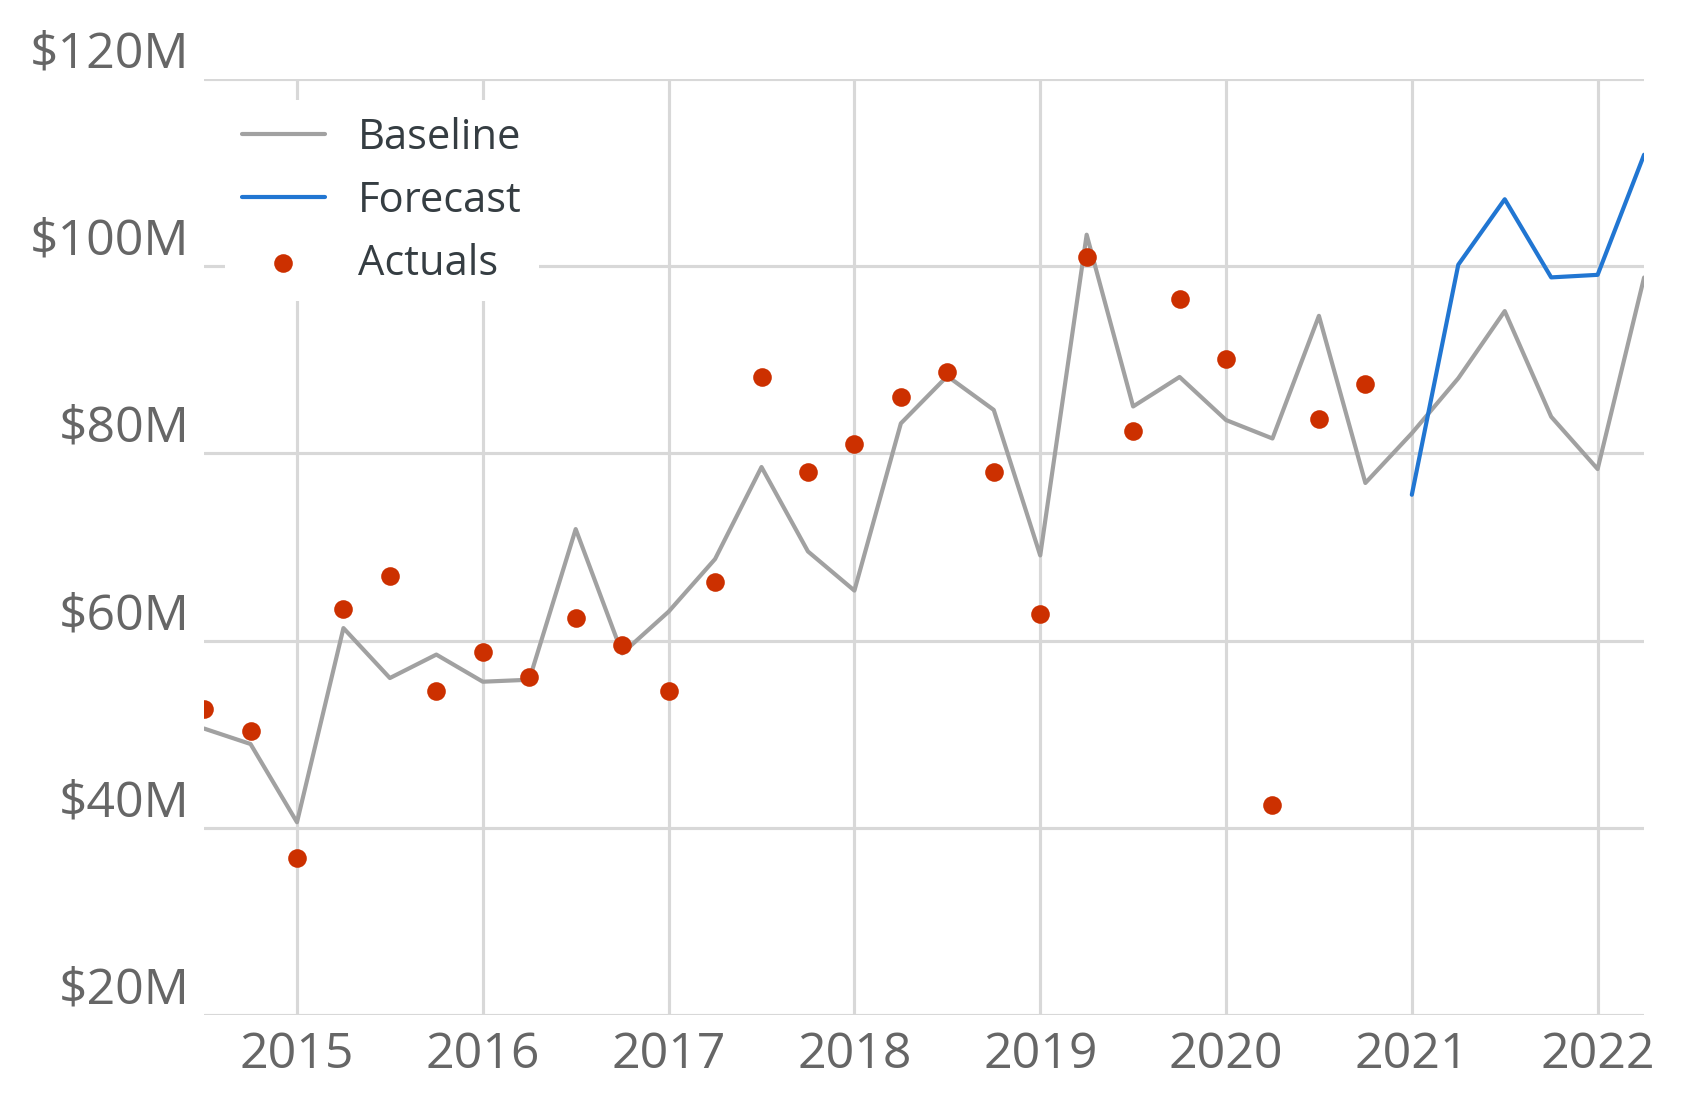

In [13]:
tax2.run_forecast("moderate")
tax2.plot();

### Severe

In [14]:
tax2.run_forecast("severe");

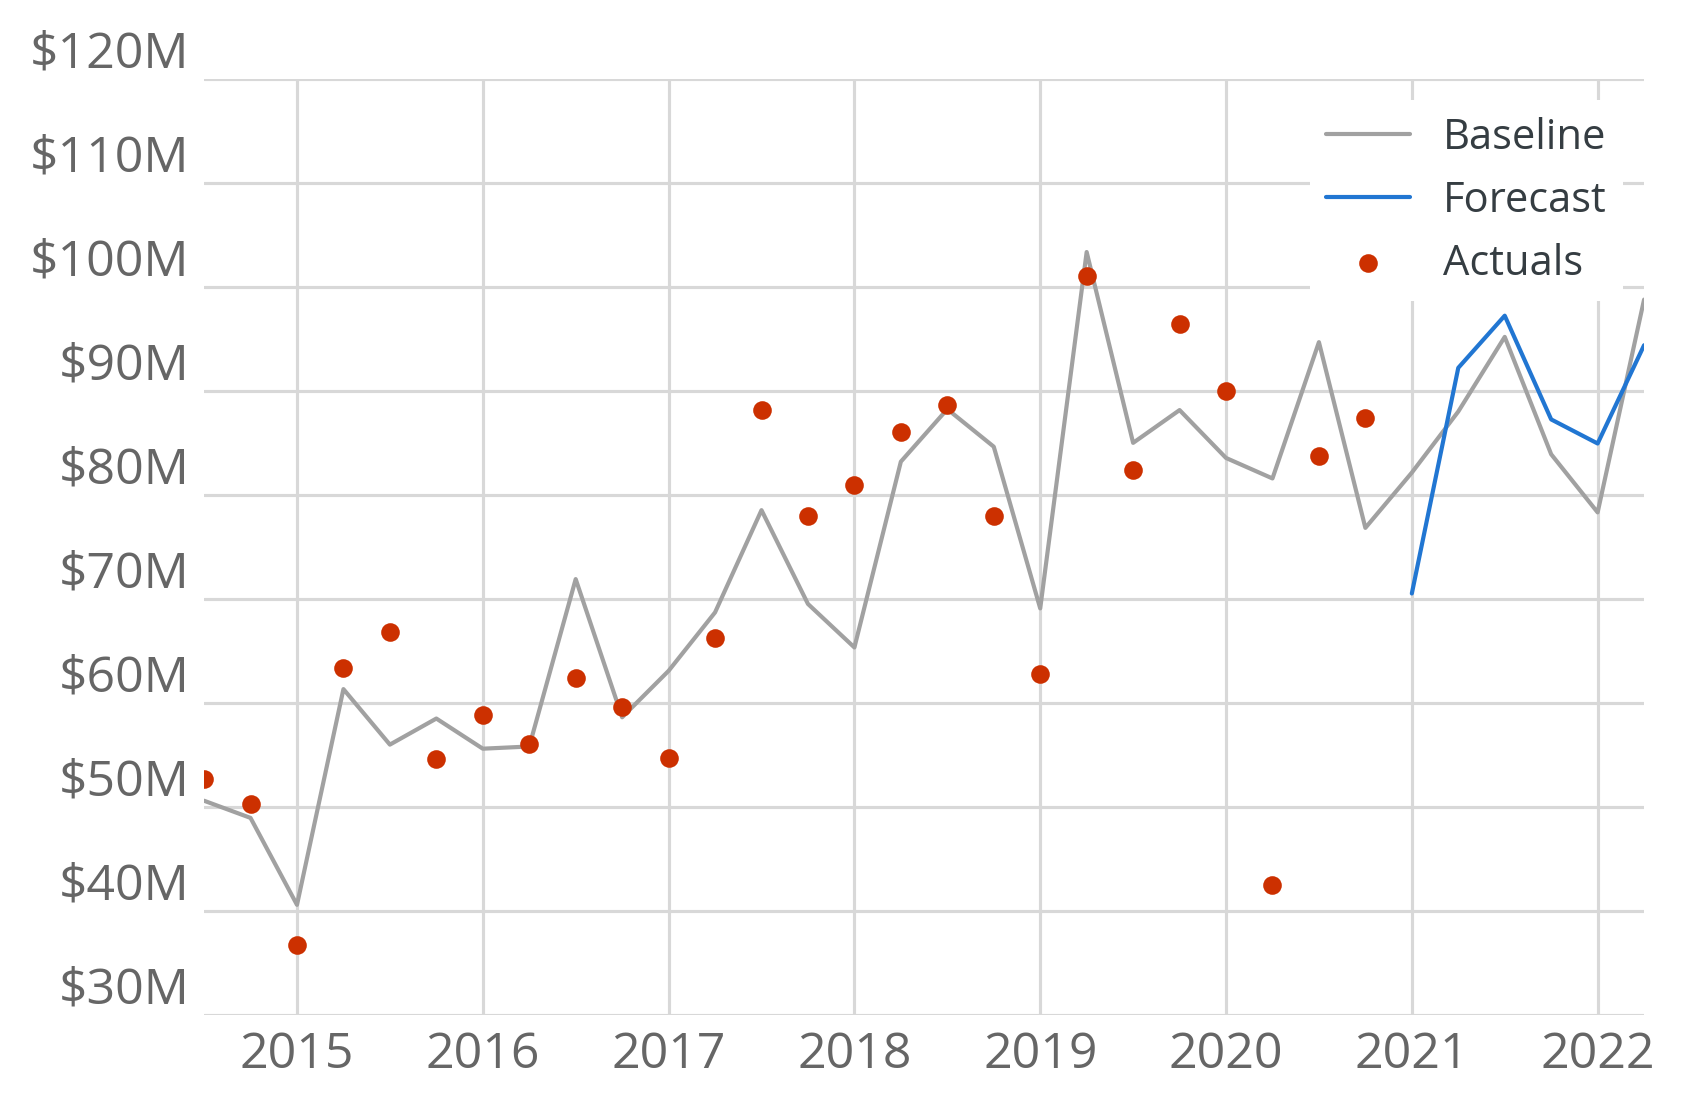

In [15]:
tax2.plot();